# I. Data Collection & Data Preprocessing
## Libraries and package installation

In [ ]:
!pip install fuzzy-c-means
!pip install scikit-fuzzy
!pip install torch
!pip install torchvision
!pip install sqlite3
!pip install datetime

In [ ]:
import torch
import torch.nn as nn 
import torch.nn. functional as F
import torchvision
import torchvision.transforms as transforms
import skfuzzy as fuzz
import sklearn.metrics as metrics
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sqlite3
import dash
import plotly.graph_objects as go

from random import sample
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
from IPython.display import display
from math import pi
from scipy.spatial.distance import mahalanobis

### Statcast 2023 Data

In [3]:
pd.read_csv(r"/Users/stephenak24/Downloads/statcast_2023.csv")
statcast_2023 = pd.read_csv(r"/Users/stephenak24/Downloads/statcast_2023.csv")

In [4]:
# Remove the excesss columns
columns_to_keep = ['player_id', 'Name','Season','Age','50th_max_velo', 'P/PA']
statcast_2023_cleaned = statcast_2023[columns_to_keep].copy()

statcast_2023_cleaned

player_id                 Name  Season  Age  50th_max_velo  P/PA
0       518934          DJ LeMahieu    2023   34          100.3  4.01
1       677594      Julio Rodríguez    2023   22          104.1  3.52
2       543807  George Springer III    2023   33          100.3  3.70
3       593428      Xander Bogaerts    2023   30           98.5  3.98
4       663728          Cal Raleigh    2023   26          101.0  4.11
..         ...                  ...     ...  ...            ...   ...
129     683002     Gunnar Henderson    2023   22          102.7  3.87
130     650402       Gleyber Torres    2023   26           99.6  3.94
131     650559     Bryan De La Cruz    2023   26          100.3  3.94
132     668715        Spencer Steer    2023   25           99.2  4.04
133     673548         Seiya Suzuki    2023   28          102.2  4.19

[134 rows x 6 columns]

### Fangraphs 2023 Data

In [5]:
pd.read_csv(r"/Users/stephenak24/Downloads/fangraphs_2023.csv")
fangraphs_2023 = pd.read_csv(r"/Users/stephenak24/Downloads/fangraphs_2023.csv")

fangraphs_2023

Name  player_id Team  Age  Season    K%   BB%  Brls/BBE%  \
0        Matt Chapman     656305  TOR   30    2023  28.4  10.7       17.1   
1           Juan Soto     665742  SDP   24    2023  18.2  18.6       13.0   
2          Matt Olson     621566  ATL   29    2023  23.2  14.4       16.4   
3    Ronald Acuña Jr.     660670  ATL   25    2023  11.4  10.9       15.3   
4       Rafael Devers     646240  BOS   26    2023  19.2   9.5       12.7   
..                ...        ...  ...  ...     ...   ...   ...        ...   
129      Ha-Seong Kim     673490  SDP   27    2023  19.8  12.0        4.3   
130       Luis Arraez     650333  MIA   26    2023   5.5   5.7        3.5   
131   Whit Merrifield     593160  TOR   34    2023  17.1   6.1        2.4   
132       Myles Straw     664702  CLE   28    2023  18.7   8.1        0.5   
133       Steven Kwan     680757  CLE   25    2023  10.4   9.7        1.1   

     HardHit%  Spd  ...  Swing%  O-Contact%  Z-Contact%  SwStr%  BsR  Pull%  \
0        56.1  3.7  ...    43.3        59.8        78.3    11.7 -0.8   39.3   
1        55.3  3.5  ...    35.7        67.6        89.9     6.3 -0.9   38.9   
2        55.1  3.1  ...    46.9        69.5        77.7    11.9  0.2   38.2   
3        55.0  7.3  ...    46.2        73.8        87.8     7.8  8.8   39.7   
4        54.7  3.0  ...    52.5        70.8        79.8    12.6 -3.2   41.1   
..        ...  ...  ...     ...         ...         ...     ...  ...    ...   
129      26.2  5.1  ...    38.5        76.3        88.2     6.0  4.2   45.1   
130      25.2  2.9  ...    50.8        91.5        95.3     3.1 -1.4   29.6   
131      24.1  4.5  ...    50.9        74.1        87.7     9.1  1.3   34.3   
132      23.1  5.9  ...    43.8        82.2        91.4     5.1  3.3   24.7   
133      18.8  6.3  ...    41.0        79.7        95.7     3.9  4.3   30.0   

     Oppo%    LA  HR  SB  
0     23.4  18.5  17   4  
1     20.7   6.7  35  12  
2     24.5  16.1  54   1  
3     24.7   7.4  41  73  
4     24.1  12.4  33   5  
..     ...   ...  ..  ..  
129   20.8  13.6  17  38  
130   31.3  11.5  10   3  
131   27.9  14.4  11  26  
132   35.3   9.4   1  20  
133   31.4  10.7   5  21  

[134 rows x 27 columns]

## Merging the dataframes

In [6]:
merged_df = pd.merge(statcast_2023_cleaned, fangraphs_2023, on='player_id', how='inner', suffixes=('_statcast', '_fangraphs'))

# Dropping the 'Name_fangraphs', 'Season_fangraphs', and 'Age_fangraphs' columns
merged_df.drop(columns=['Name_fangraphs', 'Season_fangraphs', 'Age_fangraphs'], inplace=True)

# Rename the remaining columns to remove the suffixes
merged_df.rename(columns={
    'Name_statcast': 'Name',
    'Season_statcast': 'Season',
    'Age_statcast': 'Age'
}, inplace=True)


merged_df.head()

player_id                 Name  Season  Age  50th_max_velo  P/PA Team  \
0     518934          DJ LeMahieu    2023   34          100.3  4.01  NYY   
1     677594      Julio Rodríguez    2023   22          104.1  3.52  SEA   
2     543807  George Springer III    2023   33          100.3  3.70  TOR   
3     593428      Xander Bogaerts    2023   30           98.5  3.98  SDP   
4     663728          Cal Raleigh    2023   26          101.0  4.11  SEA   

     K%   BB%  Brls/BBE%  ...  Swing%  O-Contact%  Z-Contact%  SwStr%  BsR  \
0  22.2  10.7        5.9  ...    39.2        70.3        89.8     6.8 -4.4   
1  24.5   6.6       11.9  ...    53.8        58.9        85.1    14.4  5.2   
2  18.3   8.8        7.7  ...    49.2        63.4        87.4     9.8 -0.4   
3  16.5   8.4        6.1  ...    42.6        68.6        88.3     8.1  0.9   
4  27.8   9.5       12.6  ...    49.7        59.6        80.6    14.0 -2.2   

   Pull%  Oppo%    LA  HR  SB  
0   34.5   28.1   3.8  15   2  
1   42.0   23.7   8.5  32  37  
2   39.5   24.4  12.0  21  20  
3   40.2   28.3   7.9  19  19  
4   51.1   19.9  20.3  30   0  

[5 rows x 29 columns]

# II. Exploratory Data Analysis
## Correlation Matrix


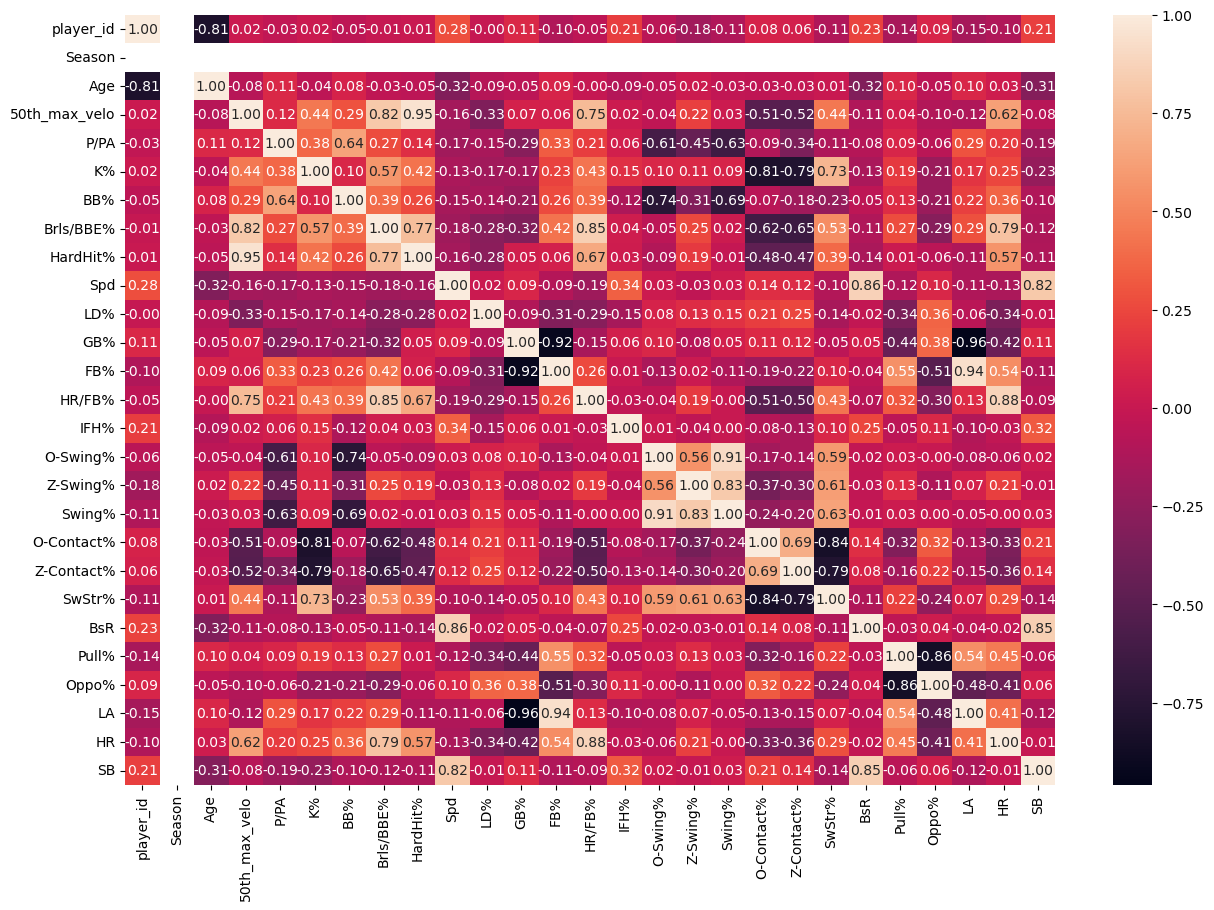

In [50]:
# Select only numeric columns
numeric_cols = merged_df.select_dtypes(include=[np.number])

plt.figure(figsize=(15, 10))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f")
plt.show()

# Scaling and Hopkins Statistic

Scaling your features is crucial for various clustering algorithms such as Fuzzy C-means, which utilizes distances to gauge the degree of membership for each data point within a cluster, and OPTICS, which relies on reachability distances to delineate clusters. Scaling helps prevent features with varying units from disproportionately influencing these distance metrics, which are highly sensitive to the scale of the data.

In [7]:
scaler = StandardScaler()

# Create a list of columns to scale, excluding 'IDfg', 'player_id', and 'Season'
columns_to_scale = merged_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
columns_not_to_scale = ['player_id', 'Season']
numeric_cols = [col for col in columns_to_scale if col not in columns_not_to_scale]

scaler.fit(merged_df[numeric_cols])

# Scale the numeric columns
merged_df[numeric_cols] = scaler.transform(merged_df[numeric_cols])

merged_df_scaled = merged_df[numeric_cols]


### The Hopkins statistic is used to assess how likely your data is to have meaningful clusters. It ranges from 0 to 1, with different ranges indicating the following:

- Close to 0.5: This suggests the data is randomly distributed, with no significant clusters.
- Between 0.7 and 0.99: This indicates a high tendency for the data to cluster. This is generally considered a good range for clustering.
- Close to 1: This is a strong indication that the data has well-defined clusters.

In [ ]:
def hopkins_statistic(X):
    n = len(X) # number of rows in the DataFrame
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    rand_X = sample(range(0, n), m)
    
    u_dist = np.array([nbrs.kneighbors([X.iloc[i].to_numpy()], return_distance=True)[0][0][1] for i in rand_X])
    v_dist = np.array([np.linalg.norm(np.random.uniform(np.amin(X, axis=0), np.amax(X, axis=0)) - X.iloc[random.choice(rand_X)]) for _ in range(m)])
    
    H = sum(u_dist) / (sum(u_dist) + sum(v_dist))
    return H

# Select numerical columns for the analysis
X = merged_df_scaled

# Calculate the Hopkins statistic
H = hopkins_statistic(X)
print(f"Hopkins statistic: {H}")

# Sequential Dimensionality Reduction Strategy
Dimensionality reduction is a tool to reduce the number of dimensions (features) in a data set. The goal of dimensionality reduction is to decrease the data set's complexity by reducing the number of features while keeping the most important properties of the original data.

In this project, I'm going to employ a two-step sequential dimensionality reduction strategy that combines Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE) to process and visualize high-dimensional data effectively. The approach will help to leverage the strengths of both linear and nonlinear dimensionality reduction techniques to prepare the dataset for clustering.

## Principal Component Analysis (PCA)

PCA transforms the original high-dimensional data into a new set of features called principal components. These components are ranked by the amount of variance they capture from the original data.

The dataset is high-dimensional and likely contains a lot of noise, which can impede the performance of clustering algorithms. To address this, I'm going to first apply PCA, a linear transformation technique, to reduce noise and compress the data while preserving as much variance as possible.

The goal for determining the number of principal components to retain in PCA is often based on capturing a certain percentage of the total variance in the dataset. A common target is to retain enough principal components to explain around 70% to 95% of the total variance.

In this case, I fit PCA to the scaled dataset to reduce the feature space to the components that cumulatively explain ~95% of the variance.

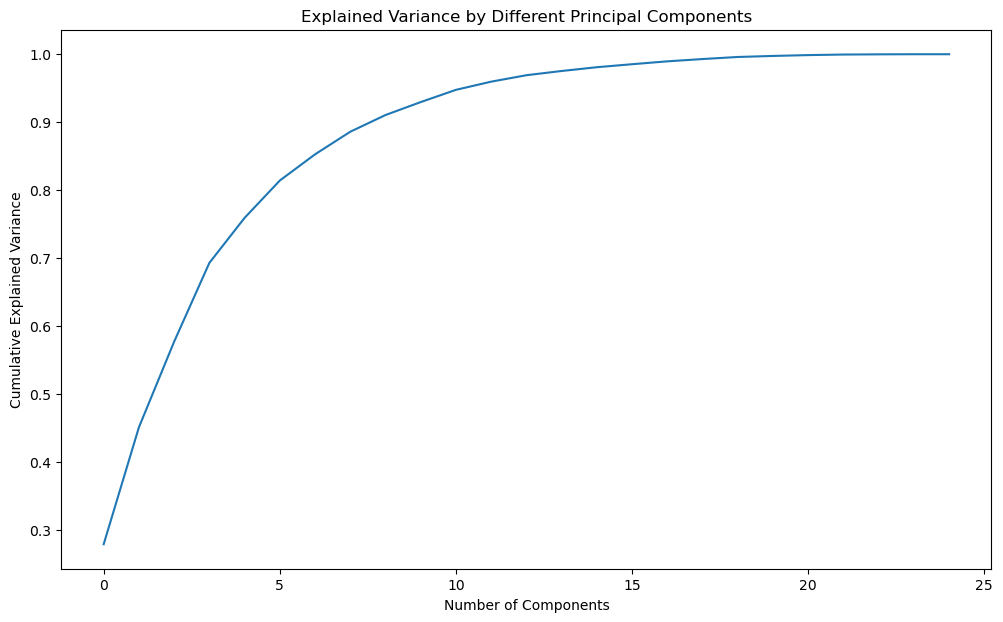

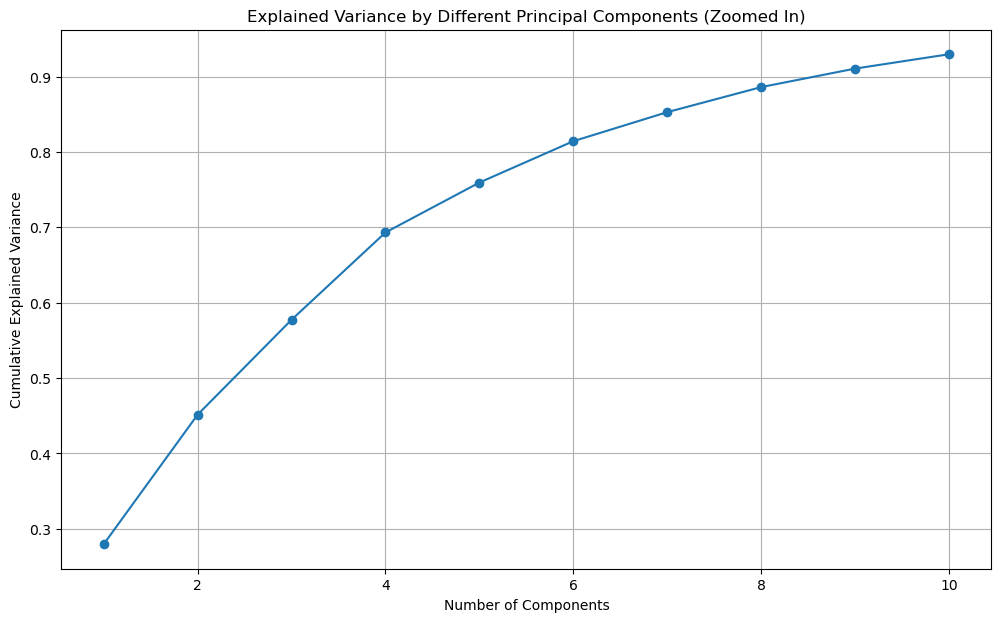

Explained Variance Ratio for Each Component:
Component 1: 27.95%
Component 2: 17.19%
Component 3: 12.59%
Component 4: 11.58%
Component 5: 6.62%
Component 6: 5.49%
Component 7: 3.85%
Component 8: 3.32%
Component 9: 2.46%
Total Explained Variance Ratio: 91.06%


In [8]:
        # Fit PCA
        pca_full = PCA()
        pca_full.fit(merged_df_scaled)
        cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

        # Plot the full explained variance to determine the region to zoom in on
        plt.figure(figsize=(12, 7))
        plt.plot(cumulative_variance)
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Explained Variance by Different Principal Components')
        plt.show()

        # Determine the component range to zoom in on
        components_to_zoom = range(1, 11) 
        cumulative_variance_zoom = cumulative_variance[:len(components_to_zoom)]

        plt.figure(figsize=(12, 7))
        plt.plot(components_to_zoom, cumulative_variance_zoom, marker='o')  # Use marker to emphasize each point
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Explained Variance by Different Principal Components (Zoomed In)')
        plt.grid(True)
        plt.show()

        pca = PCA(n_components=9)
        pca_result = pca.fit_transform(merged_df_scaled)
        
        # Explained variance ratio for each component (percentage)
        explained_variance_ratio = pca.explained_variance_ratio_ * 100

        print("Explained Variance Ratio for Each Component:")
        for i, ratio in enumerate(explained_variance_ratio):
          print(f"Component {i+1}: {ratio:.2f}%")

        total_variance = sum(pca.explained_variance_ratio_ * 100)
        print(f"Total Explained Variance Ratio: {total_variance:.2f}%")


In choosing the number of components, we face a trade-off:

**Complexity:** Retaining more components may mean preserving more information but at the cost of having a more complex model, which can be harder to interpret.


**Simplicity:** Choosing fewer components simplifies the model but may discard potentially valuable information.
The ideal balance retains enough components to capture a substantial amount of variance (often around 70-95%) without unnecessarily complicating the model.



In this case, I fit PCA to the scaled dataset to reduce the feature space to the components that cumulatively explain ~91% of the variance.

---

I began with a plot of the cumulative explained variance by different principal components. This plot shows the proportion of the dataset's total variance that each component captures. We look for the point where the curve starts to flatten out, indicating diminishing returns on explained variance with each additional component. This is often referred to as the "elbow" of the plot.
 
To make an informed decision, I further examined a "zoomed-in" view of the plot focusing on the area where the curve begins to plateau. This finer view allows us to observe more subtle changes in the explained variance and better identify the elbow.

After analyzing the plots, I decided to retain 9 principal components. This number of components provides a balance between retaining a substantial proportion of the dataset's information while avoiding overfitting and unnecessary complexity. It captures the bulk of the variance while acknowledging the diminishing returns of adding more components.



## T-distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE is a dimensionality reduction technique commonly used for visualizing high-dimensional data in lower-dimensional spaces, typically two dimensions. Unlike Principal Component Analysis (PCA), which focuses on capturing maximum variance in the data through linear combinations of features, t-SNE emphasizes the preservation of local relationships between data points. It accomplishes this by modeling the similarity between data points in high-dimensional space and representing these similarities in lower-dimensional space. This approach allows t-SNE to effectively capture complex non-linear structures and clusters present in the data, making it particularly useful for exploratory data analysis and visualization tasks.


I'm going to apply t-SNE to the output of PCA, using the dimensionally-reduced data from PCA as input to t-SNE to further compress and visualize the data in two dimensions.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.001s...
[t-SNE] Computed neighbors for 134 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 2.625022
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.467216
[t-SNE] KL divergence after 300 iterations: 0.534858


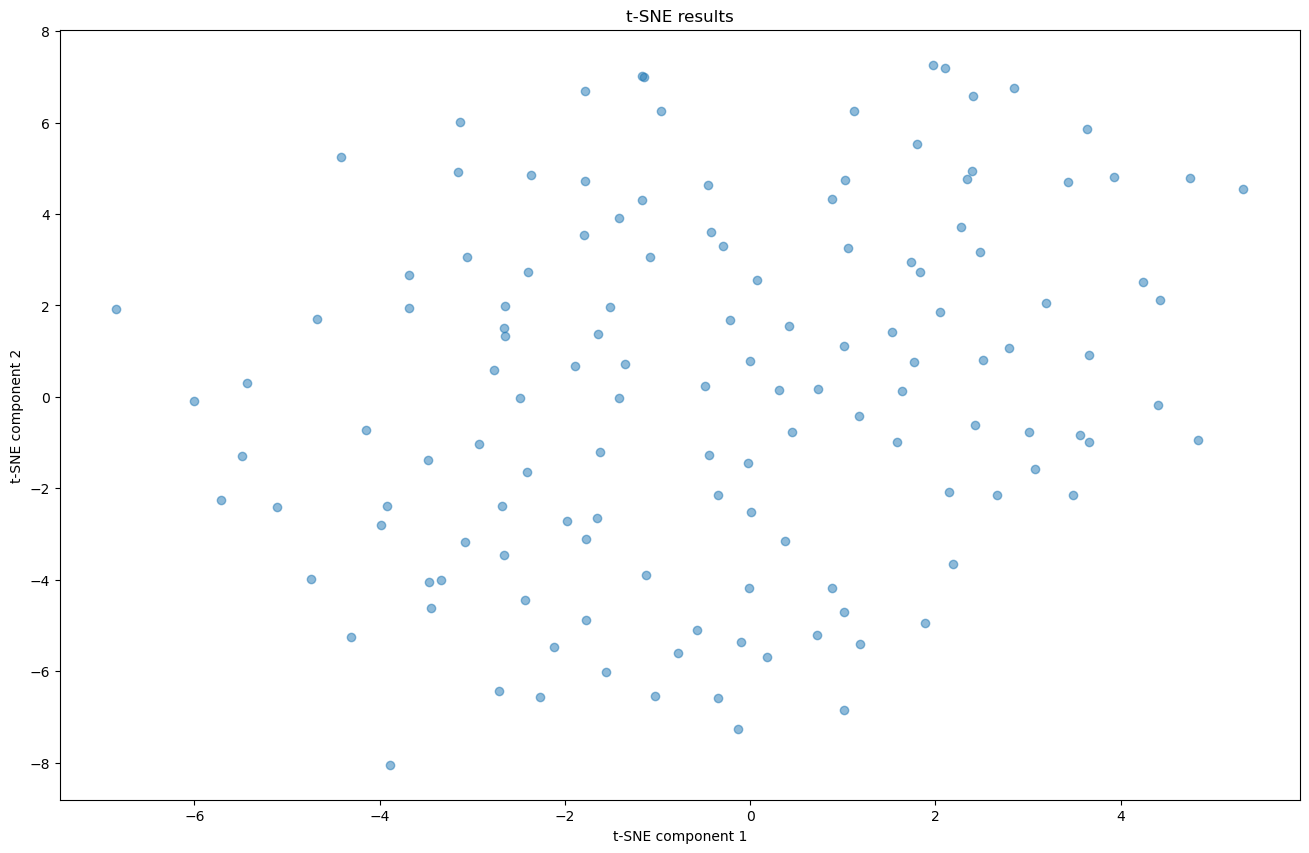

In [9]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tsne_results = tsne.fit_transform(pca_result)

plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5) # Adjust alpha for point transparency
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.title('t-SNE results')
plt.show()

Here's how to interpret the t-SNE plot:

**1. Cluster Patterns:** Look for clusters of points that are close to each other; these represent groups of hitters with similar profiles according to the data.

**2. Outliers:** Points that are far away from others could be considered outliers. They have a unique profile that sets them apart from the rest of the players.

**3. Density:** The density of points in certain areas can give you an idea of how common certain player profiles are. Sparse areas indicate less common profiles.

There appear to be some loose groupings, but there isn't a clear separation between clusters. So let's adjust the hyperparameters of t-SNE to see if there's a more consistent pattern that emerges.



[Here's a great read on the importance of  hyperparameters & how to use t-SNE in general.](https://distill.pub/2016/misread-tsne/)

[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.003s...
[t-SNE] Computed neighbors for 134 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 1.522429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.574516
[t-SNE] KL divergence after 4000 iterations: 0.882414


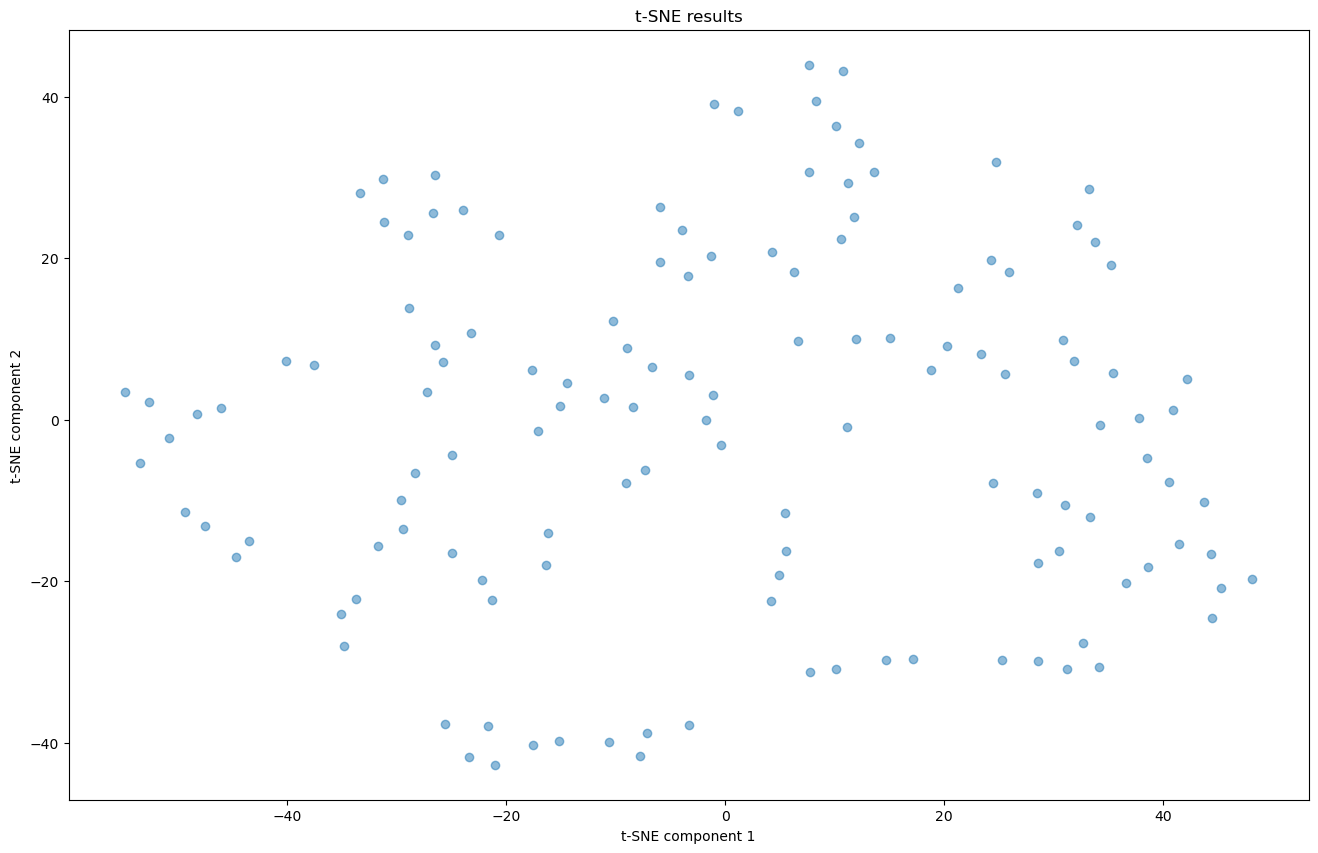

In [10]:
tsne = TSNE(n_components=2, verbose=1, perplexity=6.7, n_iter=5000) # adjust perplexity & interations if needed

tsne_results = tsne.fit_transform(pca_result)


plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5)
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.title('t-SNE results')
plt.show()

With this t-SNE plot I adjusted the perplexity, from what I've read some people like setting the perplixty to 5% of the dataset. In this case, the dataset had 134 columns so I went with 6.7.

I also upped the iterations from 300 to 5000. More iterations allows the algorithm more opportunities to converge to a stable solution where the positions of the points in the lower-dimensional space accurately represent the relationships between them in the original high-dimensional space.

The result was more distinct clusters.

**Perplexity:**
Imagine each data point on a graph as a person.
Perplexity is like asking each person, "How many close friends do you have?"
A low perplexity means each person considers only a few very close friends.
A high perplexity means each person counts a lot of friends as close.


When t-SNE is working to arrange these data points on a graph:

A low perplexity tells t-SNE to focus more on arranging points based on their very closest relationships.


A high perplexity tells t-SNE to consider more distant relationships as well, spreading the points out more evenly.

Choosing the right perplexity is like deciding how far each person's social circle extends – it affects how the points are arranged on the graph and how they relate to each other.

## More t-SNE runs and a primer on KL Divergence

[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.001s...
[t-SNE] Computed neighbors for 134 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 1.522429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.574516
[t-SNE] KL divergence after 4000 iterations: 0.882414
[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.000s...
[t-SNE] Computed neighbors for 134 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 1.522429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.574516
[t-SNE] KL divergence after 4000 iterations: 0.882414
[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.000s...
[t-SNE] Computed neighbors for 134 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 1.522429
[t-SNE] KL divergence after 250 iteratio

Text(0, 0.5, 't-SNE Component 2')

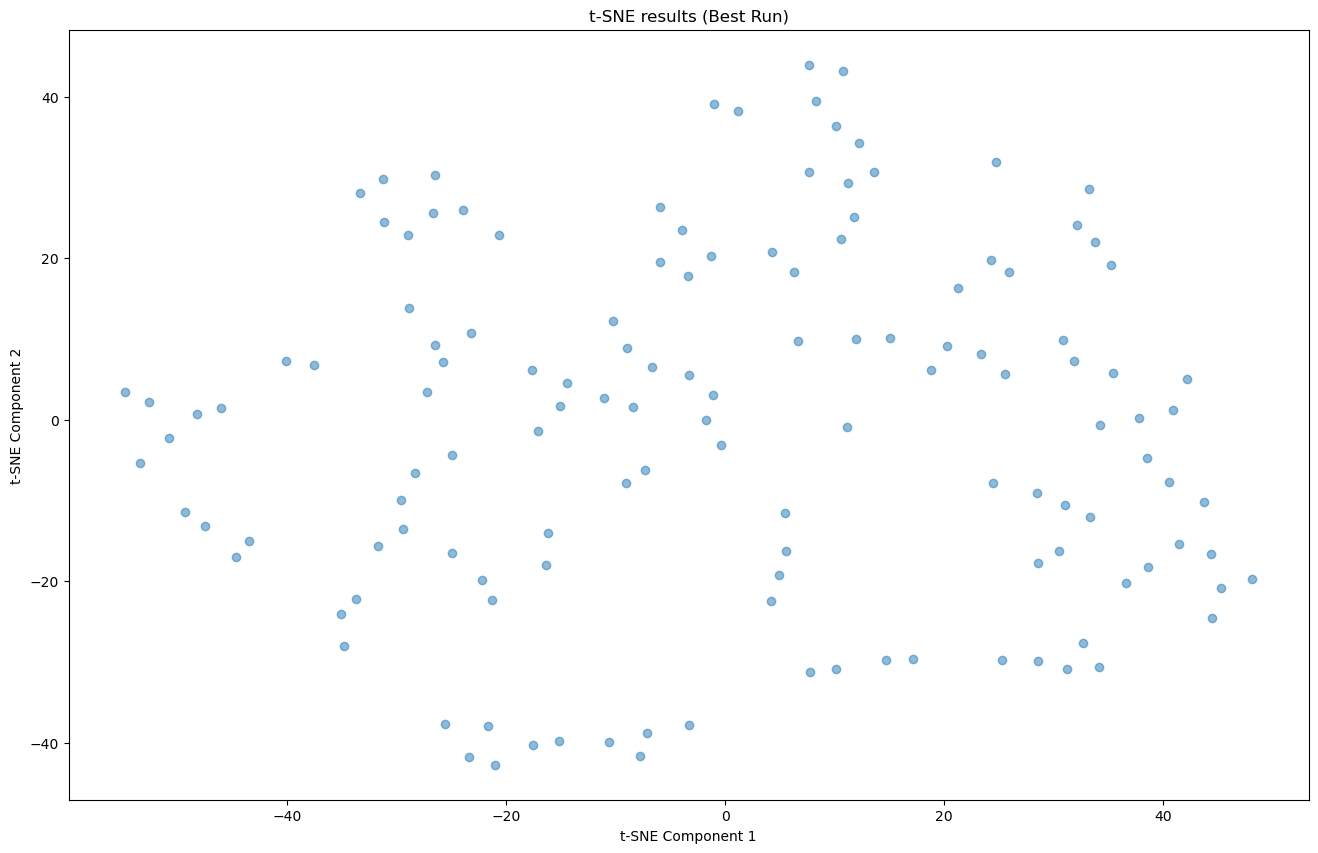

In [11]:
perplexity = 6.7
iterations = 5000
n_runs = 3

# a list that stores the KL divergence scores
kl_divergences = []

for i in range(n_runs):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=iterations, random_state=i)
    tsne_results = tsne.fit_transform(pca_result)
    kl_divergences.append(tsne.kl_divergence_)

# Find the index of the run with the lowest KL divergence
best_run_index = np.argmin(kl_divergences)
best_kl_divergence = kl_divergences[best_run_index]

print(f"Best Run Index: {best_run_index}")
print(f"Best KL Divergence: {best_kl_divergence}")

# The best model to get the corresponding t-SNE results
best_tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=iterations, random_state=best_run_index)
best_tsne_results = best_tsne.fit_transform(pca_result)

plt.figure(figsize=(16, 10))
plt.scatter(best_tsne_results[:, 0], best_tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE results (Best Run)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

This code ran the t-SNE 3 times on the PCA-reduced scaled data and recorded the KL divergence for each run. It then identified the run with the lowest KL divergence, which is considered the 'best' run in terms of having achieved a lower error between the high-dimensional and low-dimensional representations of the data, and then stored the best run under `best_tsne_results` for future visualizations.

**KL Divergence**, short for Kullback-Leibler Divergence, is a measure of the dissimilarity between two probability distributions. In the context of dimensionality reduction techniques like t-SNE, KL divergence is used to assess the similarity between the distributions of pairwise similarities in the original high-dimensional space and the lower-dimensional embedding space. The goal of t-SNE is to minimize KL divergence, thereby ensuring that the relationships between data points are faithfully preserved in the lower-dimensional representation. Lower KL divergence values indicate a closer match between the distributions, suggesting a higher-quality embedding where the structure of the data is accurately captured. Monitoring and minimizing KL divergence is essential for evaluating the effectiveness of t-SNE in capturing the underlying structure of the data and producing meaningful visualizations

In [12]:
player_names = merged_df['Name']

# Checking if the length of player names matches the number of points in best_tsne_results
assert len(player_names) == len(best_tsne_results), "The length of player names and t-SNE results must match"

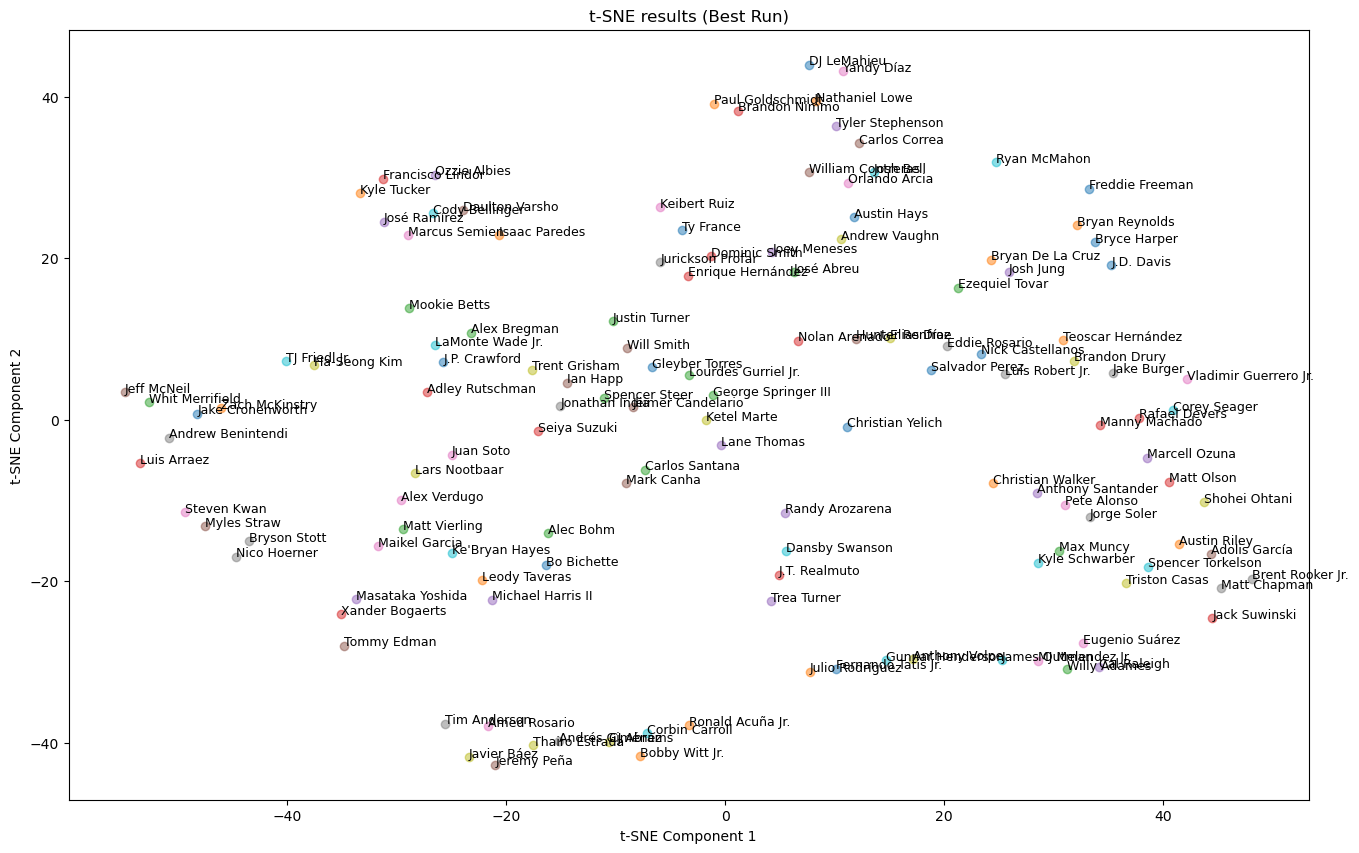

In [58]:
plt.figure(figsize=(16, 10))

# Plot each point and annotate it with the player's name
for i, (result, name) in enumerate(zip(best_tsne_results, player_names)):
    plt.scatter(result[0], result[1], alpha=0.5)
    plt.text(result[0], result[1], name, fontsize=9)

plt.title('t-SNE results (Best Run)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


# III. GMM Cluster Algorithm

## Gaussian Mixture Models (GMM)


Gaussian Mixture Models (GMM) is a probabilistic model used for clustering data points into groups or clusters. Unlike traditional clustering algorithms that assign each data point to a single cluster, GMM allows for the presence of multiple clusters within the dataset by representing each cluster as a Gaussian distribution. In a GMM, each data point is assumed to belong to one of several Gaussian distributions, with the likelihood of belonging to each distribution determined by the model's parameters. These parameters include the mean and covariance of each Gaussian distribution, as well as the mixing coefficients that specify the proportion of data points assigned to each distribution. The GMM algorithm iteratively learns these parameters using an expectation-maximization (EM) algorithm, which alternates between estimating the cluster assignments of data points (the 'expectation' step) and updating the model parameters based on these assignments (the 'maximization' step). GMM is particularly useful for modeling complex data distributions with multiple overlapping cluster.

---


The t-SNE transformed data is primarily used for visualization rather than for clustering due to t-SNE's focus on local structure preservation. t-SNE does not maintain distances in a way that's suitable for GMM. GMM assumes the data is generated from Gaussian distributions, which might not be the case after a t-SNE transformation. 

### Determining Optimal Number using Clusters Akaike (AIC) and Bayesian Information Criterion (BIC)

Before applying GMM to just the PCA-reduced dataset, we're going to use a couple of model selection criterias, Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC), to help determine the optimal number of components (clusters).

Text(0.5, 0, 'n_components')

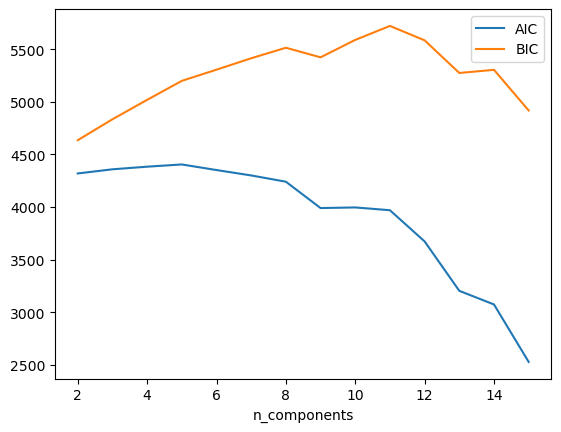

In [13]:
n_components = np.arange(2, 16)  # Try from 1 to 16 components
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(pca_result) for n in n_components]

aic = [m.aic(pca_result) for m in models]
bic = [m.bic(pca_result) for m in models]

plt.plot(n_components, aic, label='AIC')
plt.plot(n_components, bic, label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')

The number we're looking for seems to in between n_components 8 and 10. So let's take a closer look.

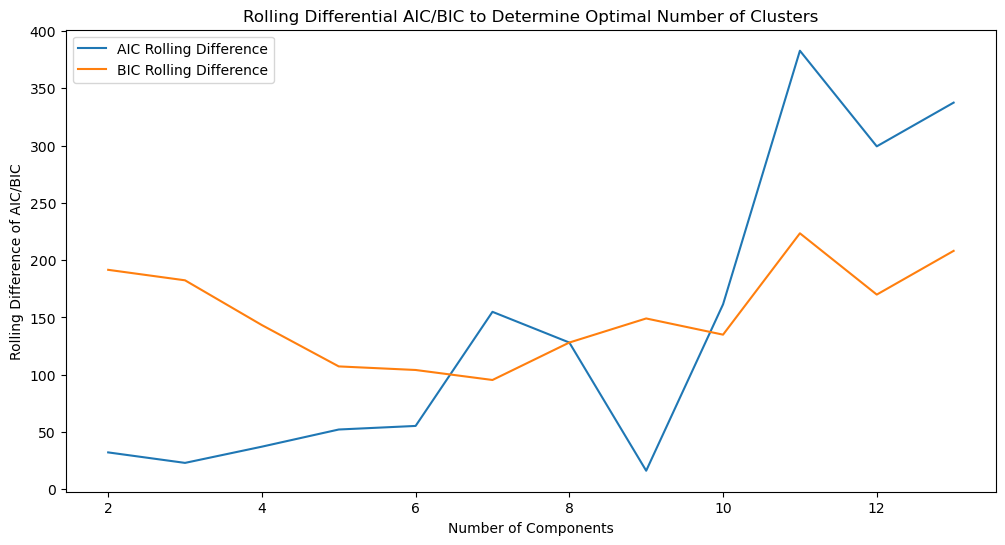

In [60]:
aic_series = pd.Series(aic)
bic_series = pd.Series(bic)

# Calculate the difference between each successive value
aic_diff = aic_series.diff().abs()
bic_diff = bic_series.diff().abs()

# Calculate the rolling mean to smooth the curve
rolling_window_size = 2
aic_rolling_diff = aic_diff.rolling(window=rolling_window_size).mean()
bic_rolling_diff = bic_diff.rolling(window=rolling_window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(aic_rolling_diff, label='AIC Rolling Difference')
plt.plot(bic_rolling_diff, label='BIC Rolling Difference')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Rolling Difference of AIC/BIC')
plt.title('Rolling Differential AIC/BIC to Determine Optimal Number of Clusters')
plt.show()

By smoothing the resulting differences using a rolling mean technique, the goal is to provide a clearer view of the trends in the data. This "zoomed-in" view of the AIC and BIC differences allowed for a pretty clear look into identifying that the optimal number of clusters is 10, as both AIC & BIC's valleys both converge at 10 components.

### Determining Optimal Number of Clusters Using Silhouette Score

To further validate if the most effective number of clusters for the Gaussian Mixture Model along PCA Component 1 and PCA Component 2, that the AIC/BIC chart gave us is true, we are going to use the silhouette score method. This score helps us assess the quality of the clusters formed by the GMM. A high silhouette score indicates that clusters are well-separated and compact, which signifies a good clustering structure.

In this section, we are going to apply Principal Component Analysis (PCA) to reduce the dimensionality of our dataset while retaining the most significant variance. We focus on the first two principal components, which capture the majority of the data's variability.

In [14]:
pca = PCA(n_components=2)  # Retain two components
pca_result = pca.fit_transform(merged_df_scaled)

# Extract Components 1 and 2 (note the index: 0 is PCA1, 1 is PCA2)
pca_1_and_2 = pca_result[:, [0, 1]]

# calculating silhouette scores
best_score = -1
optimal_clusters = 10  # start with the same number as AIC/BIC chart suggested

for n_clusters in range(2, 16):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(pca_1_and_2)
    labels = gmm.predict(pca_1_and_2)
    score = silhouette_score(pca_1_and_2, labels)
    
    if score > best_score:
        best_score = score
        optimal_clusters = n_clusters
        

print("Silhouette Score:", best_score)
print("Optimal number of clusters:", optimal_clusters)

Silhouette Score: 0.3578066061303762
Optimal number of clusters: 10


### Results:

- **Best Silhouette Score:** The highest silhouette score achieved was `{{best_score}}`, indicating the degree to which our dataset is appropriately partitioned into the optimal number of clusters, which is `{{optimal_clusters}}`.

- **Cluster Validation:** The silhouette score method agreed with our initial cluster count that AIC/BIC analysis gave us (10). This optimal cluster count ensures that the clusters are both meaningful and distinct, providing a solid basis for any subsequent analysis based on these clusters.

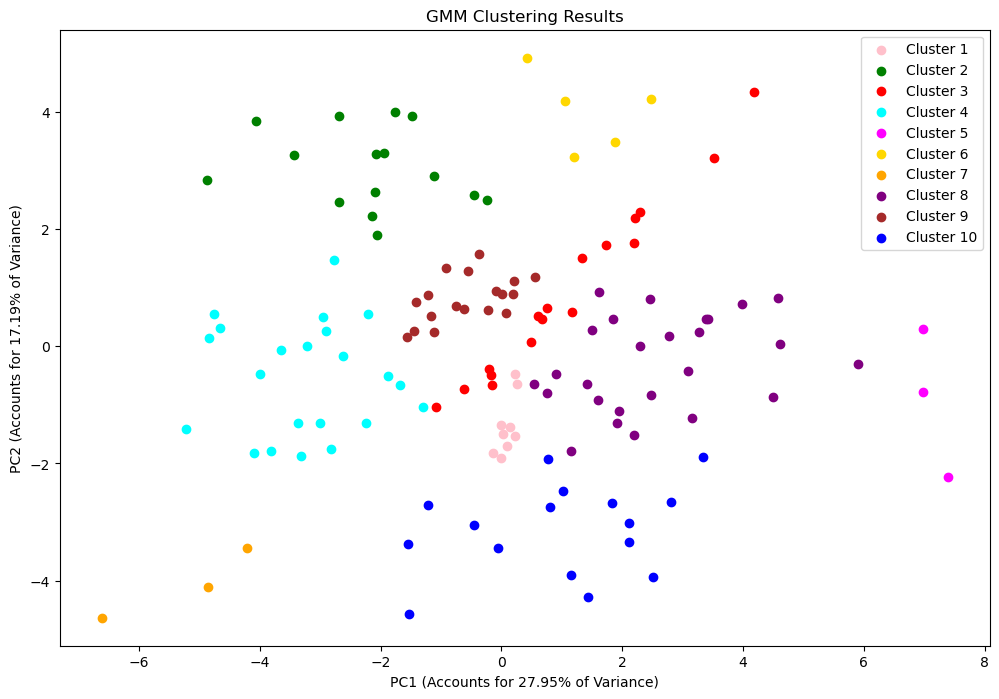

In [15]:
n_components = 10
colors = ['pink', 'green', 'red', 'cyan', 'magenta', 'gold', 'orange', 'purple', 'brown', 'blue']
gmm = GaussianMixture(n_components=n_components, random_state=77)
gmm.fit(pca_result)

# Predict the cluster for each data point and adjust to start at 1 instead of 0
labels = gmm.predict(pca_result) + 1

plt.figure(figsize=(12, 8))
for i in range(1, n_components+1):
    plt.scatter(pca_result[labels == i, 0], pca_result[labels == i, 1], color=colors[i-1],label=f'Cluster {i}')

plt.title('GMM Clustering Results')

plt.xlabel(f'PC1 (Accounts for {explained_variance_ratio[0]:.2f}% of Variance)')
plt.ylabel(f'PC2 (Accounts for {explained_variance_ratio[1]:.2f}% of Variance)')
plt.legend()
plt.show()

/var/folders/ft/2w6drxm14q597vm6scyknhc40000gn/T/ipykernel_32008/1078878735.py:23: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


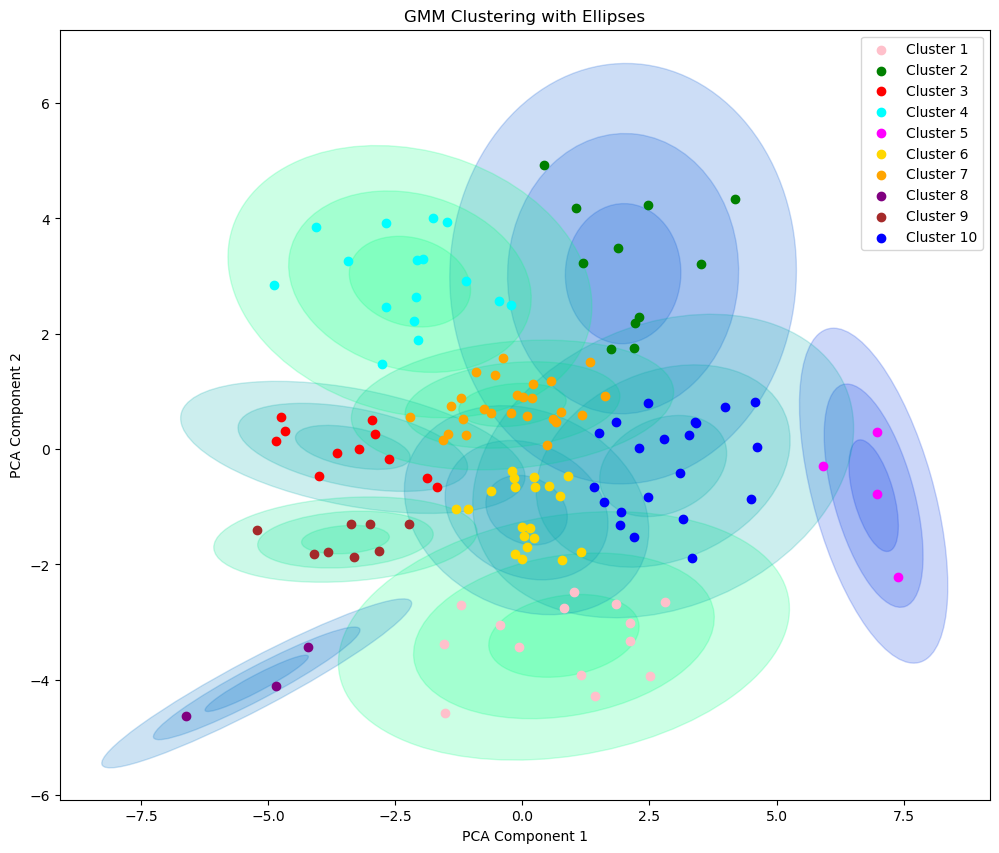

In [16]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(merged_df_scaled)

gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(pca_result)
labels = gmm.predict(pca_result)

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        
plt.figure(figsize=(12, 10))
for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    draw_ellipse(mean, covar, alpha=0.2, color=plt.cm.winter(labels[i]/float(max(labels))))

# Plot each point and color it according to the cluster label
colors = ['pink', 'green', 'red', 'cyan', 'magenta', 'gold', 'orange', 'purple', 'brown', 'blue']

for i in range(gmm.n_components):
    plt.scatter(pca_result[labels == i, 0], pca_result[labels == i, 1], 
                color=colors[i % len(colors)], label=f'Cluster {i+1}')  # for cycling through colors

plt.legend()
plt.title('GMM Clustering with Ellipses')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

/var/folders/ft/2w6drxm14q597vm6scyknhc40000gn/T/ipykernel_32008/2975983632.py:14: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipses = [Ellipse(position, nsig * width, nsig * height, angle, **kwargs)


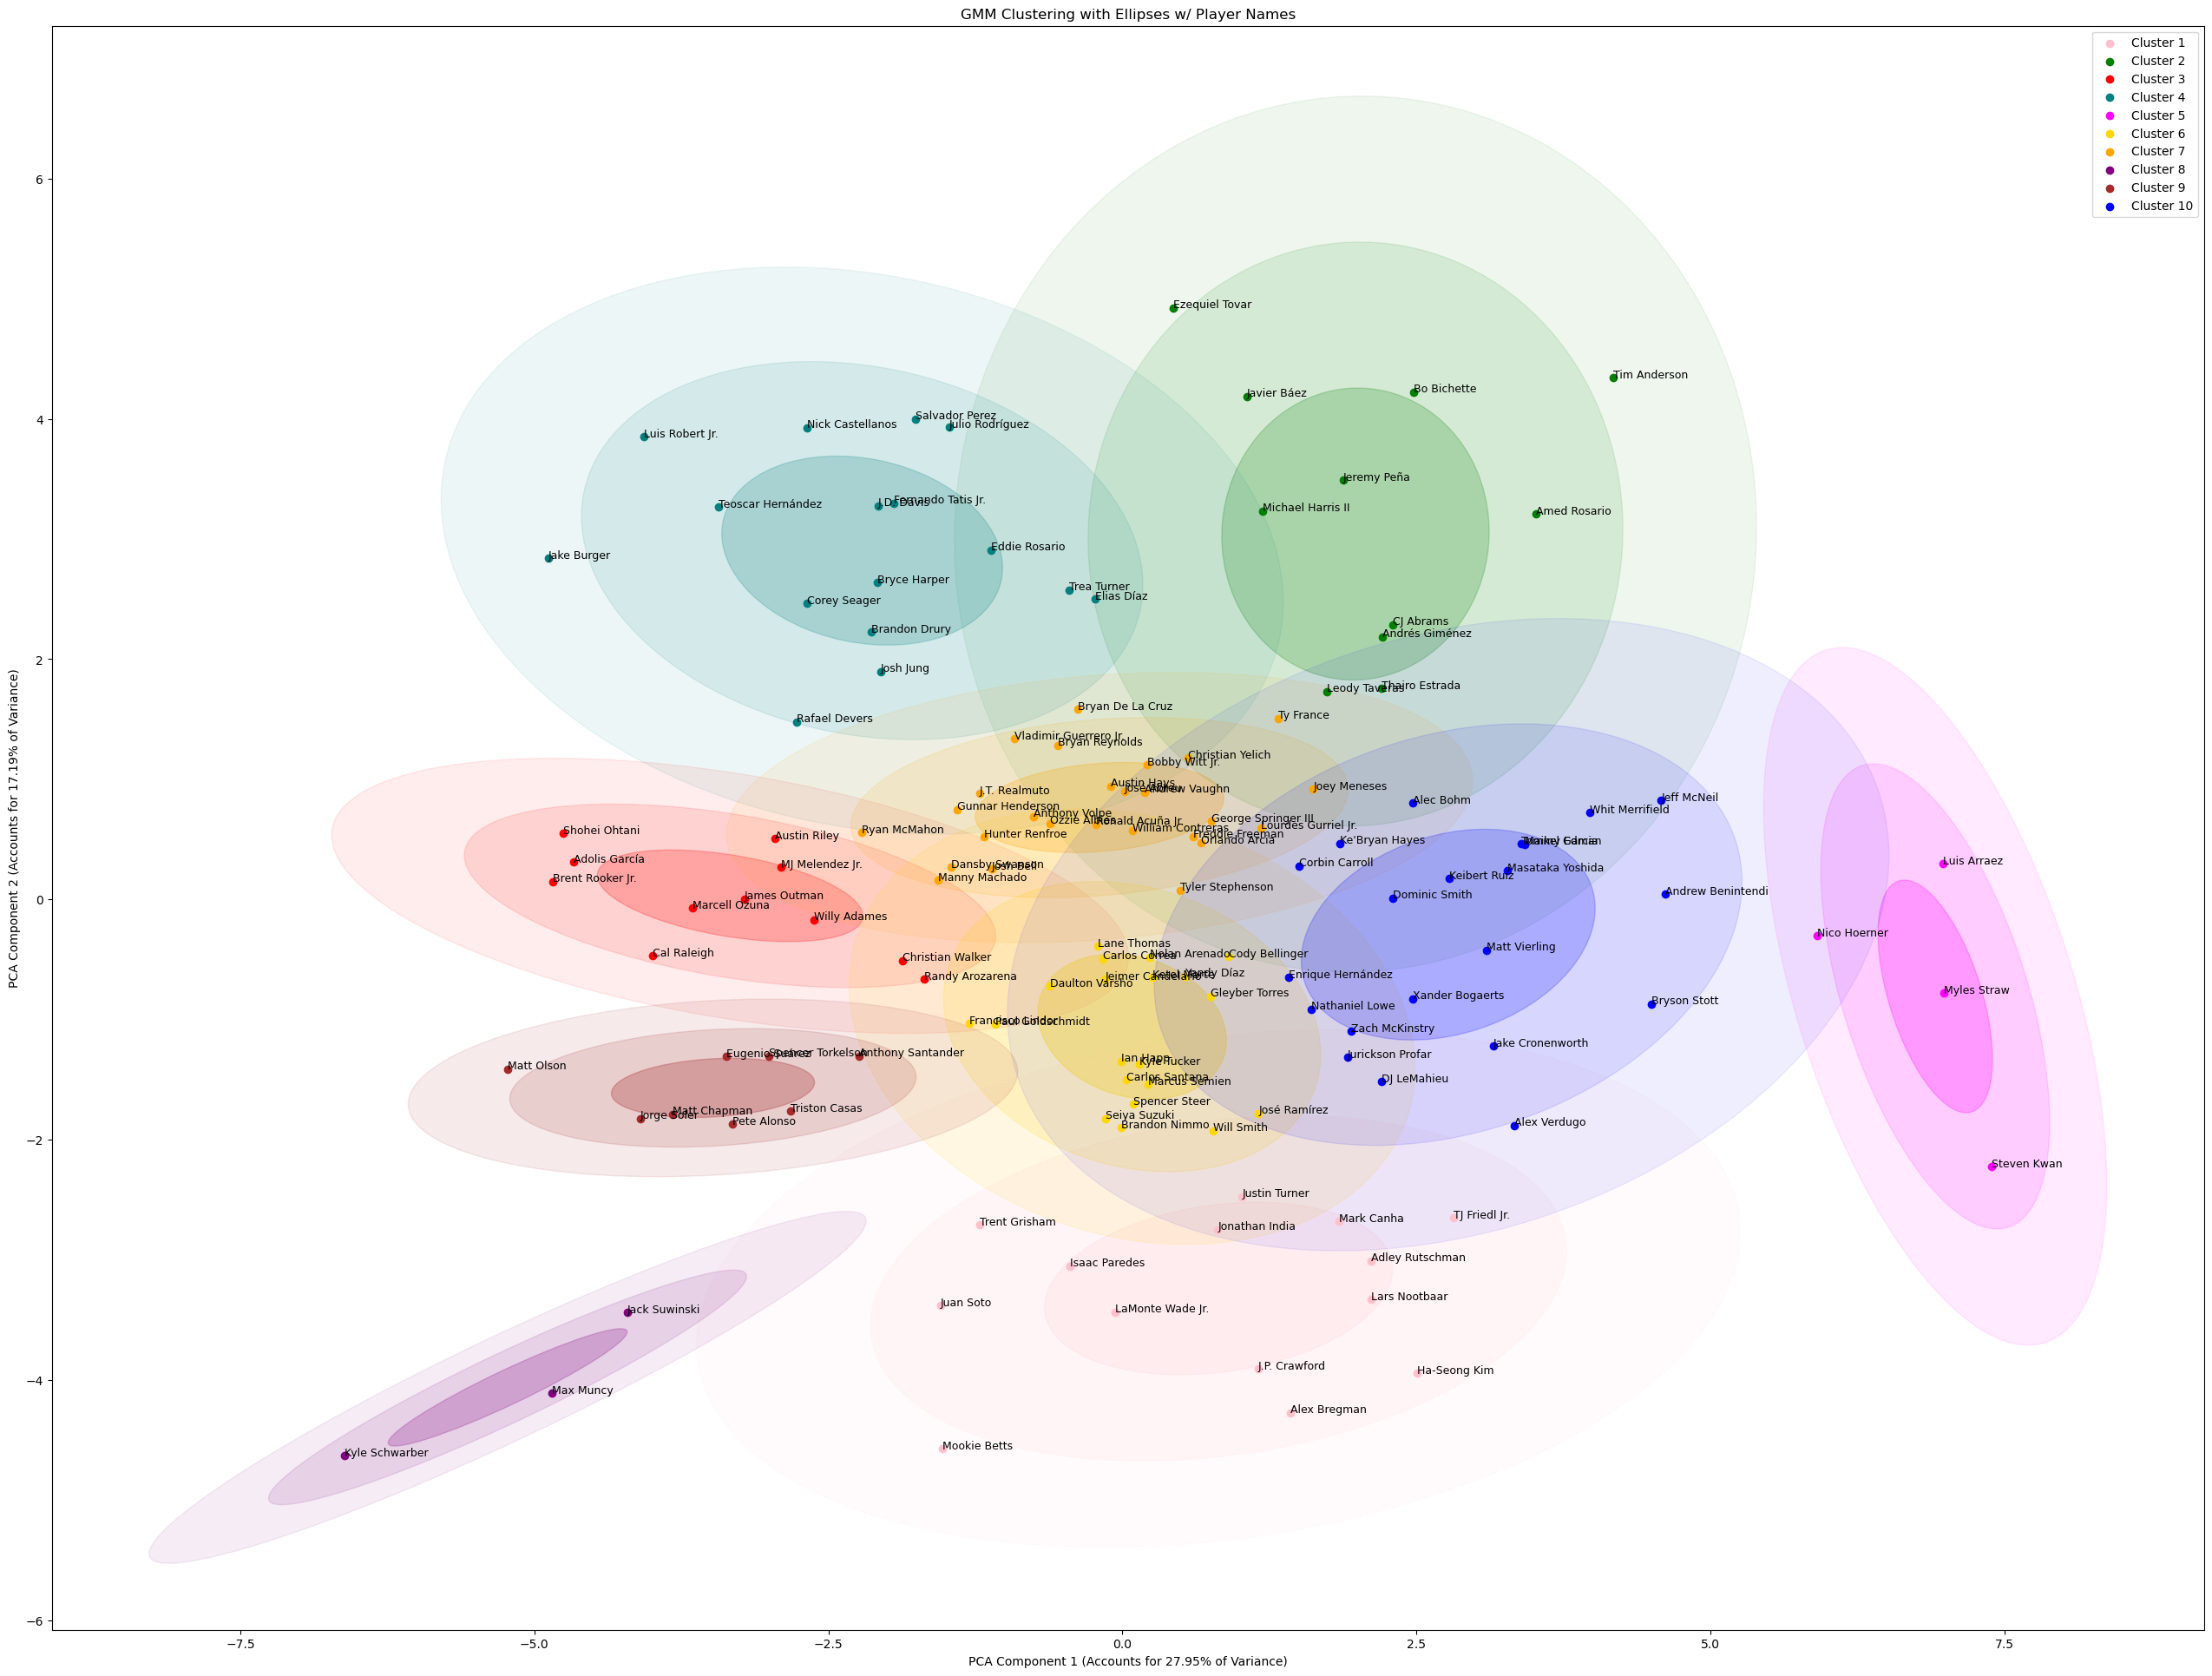

In [17]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    if covariance.shape == (2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width = height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse with different confidence intervals
    ellipses = [Ellipse(position, nsig * width, nsig * height, angle, **kwargs)
                for nsig in range(1, 4)]  # 1σ, 2σ, 3σ levels
    for e in ellipses:
        ax.add_patch(e)
        e.set_alpha(0.5 / e.width)  # Gradually decrease opacity for larger ellipses

plt.figure(figsize=(32, 24))
colors = ['pink', 'green', 'red', 'teal', 'magenta', 'gold', 'orange', 'purple', 'brown', 'blue']

# Assigning players' names to the points
for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
    ellipse_color = colors[i % len(colors)]
    draw_ellipse(mean, covar, alpha=0.2, color=ellipse_color)  # Set initial alpha for the smallest ellipse

for i in range(gmm.n_components):
    cluster_points = pca_result[labels == i, :]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i % len(colors)], label=f'Cluster {i+1}')
    for point, name in zip(cluster_points, player_names[labels == i]):
        plt.text(point[0], point[1], name, fontsize=9)

plt.legend()
plt.title('GMM Clustering with Ellipses w/ Player Names')
plt.xlabel(f'PCA Component 1 (Accounts for {explained_variance_ratio[0]:.2f}% of Variance)')
plt.ylabel(f'PCA Component 2 (Accounts for {explained_variance_ratio[1]:.2f}% of Variance)')
plt.show()

## Visualization of GMM Clustering with Confidence Ellipses and Player Names

This visualization employs the Gaussian Mixture Model (GMM) to cluster players based on PCA-reduced data, focusing on the two most significant components (PCA1 & PCA2) that capture the primary variances within the dataset. The ellipses aid the visualization making it easier to distinctly see the player groupings.

### Ellipses
- **Purpose**: Each ellipse represents one cluster from the GMM. The ellipses are designed to show not just the central tendency (mean location of the cluster in PCA space) but also the dispersion (covariance) of the data points around the mean.
- **Confidence Intervals**: The ellipses are drawn at 1σ, 2σ, and 3σ intervals. These intervals indicate areas where approximately 68%, 95%, and 99.7% of the data points (assuming a normal distribution) within each cluster are likely to be found, respectively.
- **Opacity Gradient**: The center of each ellipse is darker, signifying the area of highest data concentration (1σ), and becomes progressively lighter with larger ellipses (2σ and 3σ), visually indicating the decrease in data density as distance from the center increases.
- **Insight**: By observing where players are located relative to others within the same cluster and in relation to other clusters, insights can be gained into potential group dynamics, similarities, or differences between players.

### Interpretation
- **Cluster Analysis**: Tighter clusters with smaller ellipses suggest groups of players with more in common together and more unique than other players if isolated, while larger ellipses that overlap might indicate less distinction between some clusters but also more in common (sharing same characteristics) with other players in different clusters.

### Interesting Findings
- **Cluster 8**: Cluster 8: This cluster tied with Cluster 5 for the fewest number of players in a group, with just three players. This isn't necessarily a good or bad thing; it simply helps display the uniqueness of these seven players' skill sets. Kyle Schwarber, Max Muncy, and Jack Suwinski are all hard-hitting, strikeout-prone power bats that don't hit for average. However, the three of them do a great job of not chasing bad pitches, which helps them walk a lot. The really cool thing about this cluster is that they're all lefties (I did not include handedness as a feature in the model).

- **Cluster 5**: In contrast, while Cluster 8 comprised stoutly built, low-contact bombers, Cluster 5 is the opposite in nearly every facet. Myles Straw, Steven Kwan, Nico Hoerner and Luis Arraez all possess elite bat-to-ball skills; all their contact metrics are elite, they rarely strike out, and another significant difference is that they rarely hit home runs. The quartet combined for 25 home runs in 602 games during the 2023 season.
---
This visualization is useful for spotting patterns, understanding player dynamics, and identifying outliers or players who are positioned significantly away from their cluster centers. Viewing the players within their cluster groupings helps provide insights into any potential similarities or differences among players that might not be immediately apparent from the statistical data alone.

# IV. Gaussian Mixture Models EDA
## Median Distances

In [18]:
pca_1_and_2 = pca_result[:, [0, 1]]  # Selecting PCA1 and PCA2

cluster_median_distances = []

# Calculate median distances for each cluster
for i in range(gmm.n_components):
    # Extract the points belonging to the current cluster
    cluster_points = pca_result[labels == i]
    
    # Calculate pairwise distances between all points in the cluster
    pairwise_distances = pdist(cluster_points)
    
    # Calculate the median distance
    median_distance = np.median(pairwise_distances) if len(pairwise_distances) > 0 else 0
    
    cluster_median_distances.append((i+1, median_distance))

# Sort the clusters by median distance (closeness)
cluster_median_distances.sort(key=lambda x: x[1])

df_median_distances = pd.DataFrame(cluster_median_distances, columns=['Cluster', 'Median Distance'])

print("Clusters ranked by closeness (median pairwise distance):")
print(df_median_distances.to_markdown(index=False))

Clusters ranked by closeness (median pairwise distance):
|   Cluster |   Median Distance |
|----------:|------------------:|
|         9 |          0.973245 |
|         6 |          1.06464  |
|         7 |          1.19476  |
|         5 |          1.36265  |
|         3 |          1.42794  |
|        10 |          1.59408  |
|         4 |          1.78964  |
|         8 |          1.83443  |
|         1 |          1.85559  |
|         2 |          1.85666  |


The table above shows the clusters ranked by their median pairwise distances within each cluster. This metric provides a measure of cluster tightness, less influenced by outliers compared to the mean distance. The median distance is a value such that half the points in the cluster are closer to each other than this distance, and half are further away.

Clusters are labeled from 1 to 10, with lower median distances suggesting tighter and more cohesive clusters. A smaller median pairwise distance was thought to signify that players within that cluster were generally closer to the median center of the cluster. Conversely, a larger median distance could suggest a more spread-out cluster with potential subgroups or outlier players.

After further analysis, shifting to using the **Mahalanobis distance** within the same PCA-reduced space, will allow for a more nuanced understanding of cluster cohesion. The Mahalanobis distance in this context considers the variance-covariance structure of the data in the reduced PCA space, offering insights into how far each player is from the cluster's centroid while accounting for the shape and spread of the cluster within this lower-dimensional representation. Unlike the Euclidean distance, which treats all directions equally, the Mahalanobis distance is particularly useful for identifying outliers or understanding the "closeness" of points in this specific PCA-transformed space.

The raw numbers in the table provide a numerical measure of player closeness within clusters based on median pairwise distances. However, to better visualize and comprehend the relative compactness of clusters, we're going to introduce a box plot, this will allow us to gain more insights into the distribution within each cluster.


## Box Plots (Mahalanobis Distances)

In [132]:
merged_df_scaled_v2 = pd.read_csv('/Users/stephenak24/Downloads/merged_df_scaled_v2.csv')

# Drop non-numeric columns
numeric_df = merged_df_scaled_v2.select_dtypes(include=[np.number])

# Calculate the covariance matrix and its inverse
cov_matrix = np.cov(numeric_df.values, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calculate the Mahalanobis distance for each row (player)
mean_values = numeric_df.mean(axis=0).values
mahalanobis_distances = numeric_df.apply(lambda row: mahalanobis(row.values, mean_values, inv_cov_matrix), axis=1)

# Add the Mahalanobis distance as a new column
merged_df_scaled_v2['Mahalanobis_Distance'] = mahalanobis_distances


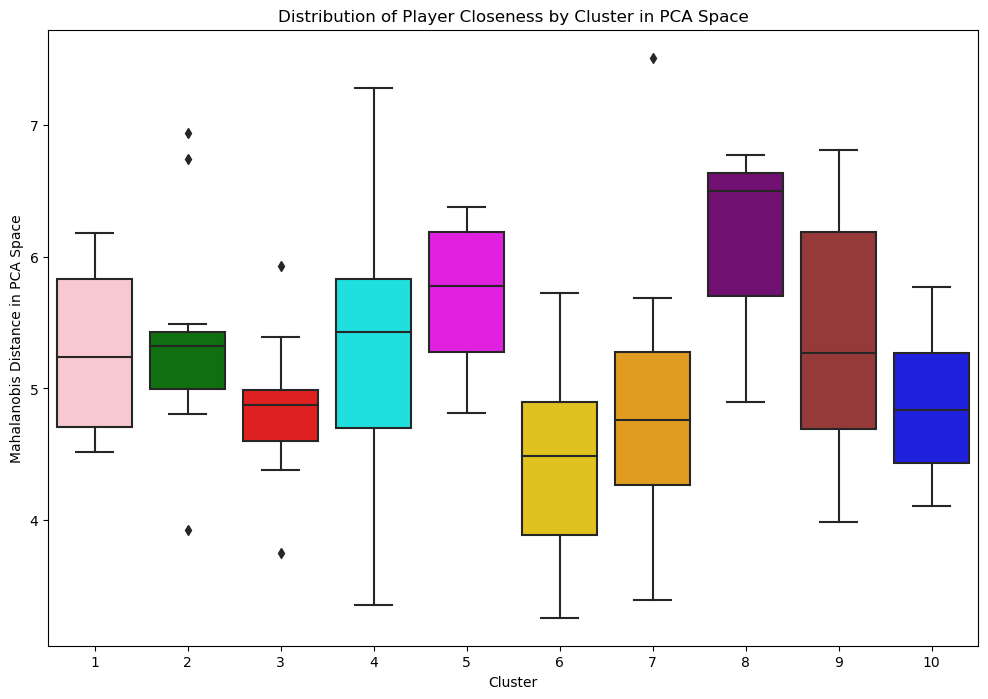

In [140]:
file_path = '/Users/stephenak24/Downloads/merged_df_mahalanobis.csv'
mahalanobis_df = pd.read_csv(file_path)

# Mapping of clusters to their colors
cluster_color_map = {
    1: 'pink',
    2: 'green',
    3: 'red',
    4: 'cyan',
    5: 'magenta',
    6: 'gold',
    7: 'orange',
    8: 'purple',
    9: 'brown',
    10: 'blue'
}

# Create the box plot for Mahalanobis distances by cluster
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Mahalanobis_Distance', data=mahalanobis_df, palette=[cluster_color_map[x] for x in sorted(cluster_color_map.keys())])
plt.title('Distribution of Player Closeness by Cluster in PCA Space')
plt.ylabel('Mahalanobis Distance in PCA Space')
plt.xlabel('Cluster')
plt.show()


The box plot above illustrates the distribution of Mahalanobis distances for players across the ten identified clusters. This plot provides insight into the relative compactness and homogeneity of each cluster based on the distances in the PCA space.

We can quickly identify which clusters are the tightest, and which ones are more dispersed. A smaller IQR and close whiskers suggest that the players in these clusters have relatively similar Mahalanobis distances, indicating homogeneity within the cluster. We can interpret this as the players in these clusters are most alike in terms of their offensive skills.

**Cluster 1 (Disciplined Contact Oriented Hitters) :** contains big time players like Mookie Betts and Juan Soto, but it also includes someone like LaMonte Wade Jr. On the surface, Betts and Wade Jr. might seem far apart in terms of hitting style, but a deeper look at the features clustered upon reveals their similarities. Both players excel in avoiding strikeouts and drawing walks, showcasing low chase (`o-swing%`) and whiff rates (`SwStr%`) alongside strong bat-to-ball skills. The key difference lies in Betts' ability to hit the ball with exceptional power, which positions him on the edge of the cluster's ellipse (3σ interval) and edging towards the power-centric Cluster 8, which includes hitters like Schwarber, Muncy, and Suwinski.

**Cluster 2 (Young Aggresive Speedsters) :** shows a similar level of compactness, though with a slightly tighter grouping of players and a few outliers; we'll touch on those later. This cluster sees the fewest amount of pitches per plate appearance, chase at more pitches out of the zone and draw walks at the lowest rate out of all the clusters. What they do have going for them though is that they are characterized by players with dynamic speed and aggressive style of play, both at the plate and on the bases. CJ Abrams and Michael Harris II are a couple of players that exemplify these tendencies within the cluster: both showcase above-average sprint speeds, and their willingness to steal bases is evident, as seen in Abrams’ 47 stolen bases in 2023. But they both chased quite a bit in 2023. This cluster represents a group of players who have not yet fully developed their plate discipline and have lacked power thus far into their career. But the good news for most of the players in this cluster is that they are young; Cluster 2 is the youngest cohort of the 10 groupings.


On the other hand, **Cluster 4 (Diverse Power Hitters with Aggressive Tendencies)**, is characterized by a wide range of offensive profiles, with players who share a focus on power but differ more significantly in other aspects of their game. The cluster's broad IQR and spread in Mahalanobis distances reflect this diversity.

Trea Turner represents one end of the spectrum in Cluster 4. Turner is one of the more versatile players within this cluster, with that signature power & speed combination that most teams crave. The speed aspect of his game is what truly sets Turner apart, it allows him to not only be a threat on the bases but also to stretch hits into extra bases, which is a significant asset that complements his power-hitting capabilities. Despite his over aggressivenes with pitches out of the zone (and poor contact rates on those swings) and a below-average walk rate (6.5%), Turner’s ability to recognize pitches within the zone and swing frequently at them allows hist above average power to be leveraged more, even at lower contact rates. Still his approach at the plate is relatively balanced compared to some of the more extreme free-swingers in this cluster.

On the other end of the cluster, Luis Robert Jr. exemplifies a more traditional power hitter within Cluster 4, but with an added element of pronunced aggression. Robert Jr's `50th_max_exit_velo` (101.8 mph) & `hard_hit%` (41.7%) are comparable to Turner's, but his approach at the plate is far more aggressive, as shown by his elevated swing rates, his 28.9% strikeout rate (`K%`) and a lower walk rate of just 5.0% (`BB%`). Despite this, Robert Jr. has big time power as reflected in his 15.2% barrel rate (`Brls/BBE%`) and his ability to drive the ball with authority. However, unlike Turner, Robert's speed, while still above average, is less of a defining feature as Turner.

The contrast between Turner and Robert Jr. in Cluster 4 underscores the idiosyncrasies that can exist between players even within the same cluster. These differences highlight the diversity of skill sets within a group broadly characterized by power and aggression. Although they share similarities in their offensive strategies, the distinct ways they apply their skills demonstrate the varied talents present in this cluster.

**Cluster 9 (Three True Outcome Sluggers: Patient Power Hitters with Promising Young Stars)**, shares a box plot similar to the aforementioned Cluster 4. The players in this cluster see the second most pitches per plate appearance (`P/PA`) among the ten groups, despite their high strikeout rates, they manage to draw walks at an impressive rate, avoiding chasing pitches outside the zone. This disciplined approach complements their raw power, as they boast the highest `50th_max_velocity` pure across all clusters.


The broader interquartile range (IQR) of this cluster suggests that while these players share core characteristics—such as elite power and a disciplined approach at the plate—there are distinctions in how they achieve success. The differences within this cluster come down to the nuances in contact quality, even among this elite group of power hitters. The comparison between Matt Olson and Triston Casas helps illuminate why this cluster is more dispersed than others.

Matt Olson represents the elite side of Cluster 9. His power metrics are among the best in the league, with `hard_hit%`, Barrels per Batted Ball Event (`Brls/BBE%`), and 50th max velocity all placing him in the upper 90th percentile. Consistent with the other batters in this group, Olson ability to draw walks (14.4%) with his great eye makes him so valuable.

On the other hand, Triston Casas—a promising young star—is also extremely impressive. His power metrics are all great, but they fall into the 80th percentile, making him a notch below Olson, Soler and other guys in terms of raw power. However, Casas’s swing decisions are highly advanced for his age, even better than Olson’s in some aspects, such as his ability to avoid chasing pitches out of the zone. This mix of strong but not yet elite power, coupled with excellent plate discipline, places Casas in a slightly different area within the cluster, contributing to the broader spread observed in the box plot. 

Additionally, the age disparity within Cluster 9 further explains the cluster’s variability, coming in as the 2nd most influential metric for the group. This is promising the younger guys in this group like Casas and Spencer Torkelson.
    
 `Top 5 Influential Metrics (Cluster 9)`
    
    HardHit%     5.601387
    Age          3.226564
    K%           2.816755
    Brls/BBE%    2.190849
    BB%          2.083781

While all members are power hitters with a patient approach, the differences in contact quality and career stage lead to a broader range of profiles, making this cluster both unique and worth watching, particularly as the younger stars continue to develop.


In summary, the compact clusters, such as Clusters 1 and 2, represent groups of players with closely aligned offensive skills, reflecting high homogeneity. In contrast, the dispersed clusters, particularly Clusters 4 and 9, capture a broader spectrum of player profiles.


In [169]:
merged_df = pd.read_csv('/Users/stephenak24/Downloads/merged_df.csv')

cluster_9_players = merged_df[merged_df['Cluster'] == 9]

# Drop non-numeric columns and columns you don't want to include in the analysis
numeric_columns = cluster_9_players.select_dtypes(include=['float64', 'int64']).drop(columns=['player_id', 'Unnamed: 0', 'HR'])

# Calculate the standard deviation for all numeric metrics within Cluster 9
cluster_9_variance = numeric_columns.std()

# Sort the standard deviations in descending order to find the top 5 most influential metrics
top_5_influential_metrics = cluster_9_variance.sort_values(ascending=False).head(5)

# Display the top 5 influential metrics
print(top_5_influential_metrics)

O-Contact%    6.273741
HR/FB%        6.073773
HardHit%      5.601387
O-Swing%      4.410053
Pull%         4.012102
dtype: float64


In [170]:
file_path = '/Users/stephenak24/Downloads/merged_df_mahalanobis.csv'
mahalanobis_df = pd.read_csv(file_path)

# Calculate the IQR and determine the outliers for each cluster
outliers = pd.DataFrame()

for cluster in mahalanobis_df['Cluster'].unique():
    cluster_data = mahalanobis_df[mahalanobis_df['Cluster'] == cluster]
    
    Q1 = cluster_data['Mahalanobis_Distance'].quantile(0.25)
    Q3 = cluster_data['Mahalanobis_Distance'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    cluster_outliers = cluster_data[(cluster_data['Mahalanobis_Distance'] < lower_bound) | 
                                    (cluster_data['Mahalanobis_Distance'] > upper_bound)]
    
    outliers = pd.concat([outliers, cluster_outliers])

# Order the outlier data by Cluster and Mahalanobis_Distance
outliers_sorted = outliers.sort_values(by=['Cluster', 'Mahalanobis_Distance'])

print(outliers_sorted[['Name', 'Cluster', 'Mahalanobis_Distance']])


                 Name  Cluster  Mahalanobis_Distance
91      Leody Taveras        2              3.925271
100       Bo Bichette        2              6.740417
47       Tim Anderson        2              6.945424
4         Cal Raleigh        3              3.748805
68      Shohei Ohtani        3              5.928308
11   Ronald Acuña Jr.        7              7.514156


As you can see their are a few of symbols above the box plots for clusters 2, 3 & 7. Those symbols are outlier markers. This happens when there are data points beyond 1.5 times the interquartile range (IQR) above the third quartile or below the first quartile. This is an indication of unique players who don’t fit neatly within the defined group. These players were Leody Taveras, Bo Bichette and Tim Anderson, in Cluster 2, Cal Raleigh and Shohei Ohtani within Cluster 3, and Ronald Acuña Jr. in Cluster 7.

                Name  Cluster  Mahalanobis_Distance
    91      Leody Taveras        2              3.925271
    100       Bo Bichette        2              6.740417
    47       Tim Anderson        2              6.945424
    4         Cal Raleigh        3              3.748805
    68      Shohei Ohtani        3              5.928308
    11   Ronald Acuña Jr.        7              7.514156


## Cluster Profiles

We have a summary table of the averages of the features we used for each cluster.

In [151]:
file_path = '/Users/stephenak24/Downloads/merged_success_v55.csv' 
merged_df = pd.read_csv(file_path)

# Select only numeric columns for averaging (excluding non-numeric columns like names or identifiers)
numeric_cols = merged_df.select_dtypes(include=[float, int]).columns.tolist()

numeric_cols = [col for col in numeric_cols if col not in ['Cluster', 'player_id']]

# Compute the mean of each numeric feature for each cluster
cluster_summary = merged_df.groupby('Cluster')[numeric_cols].mean().round(2).reset_index()

# Count the number of players in each cluster
cluster_counts = merged_df.groupby('Cluster').size().reset_index(name='Player Count')

# Combine the counts with the summary stats
cluster_summary = pd.merge(cluster_summary, cluster_counts, on='Cluster', how='left')

# Reorder columns to move 'Player Count' before other metrics
cols = cluster_summary.columns.tolist()
if 'Player Count' in cols:
    cols.insert(1, cols.pop(cols.index('Player Count')))
cluster_summary = cluster_summary[cols]

# Set display option to show all columns 
pd.set_option('display.max_columns', None) 

# Display the DataFrame 
display(cluster_summary)

Cluster  Player Count    Age  Season      PA    wRC+  xwOBA    OFF   xBA  \
0        1            14  28.00  2023.0  603.00  123.43   0.35  18.56  0.26   
1        2            11  25.18  2023.0  574.45   91.00   0.31  -3.67  0.26   
2        3            11  27.91  2023.0  614.09  123.45   0.35  17.79  0.25   
3        4            16  28.44  2023.0  591.75  114.94   0.34   9.81  0.27   
4        5             4  26.25  2023.0  635.25  100.75   0.31   5.05  0.28   
5        6            20  29.15  2023.0  639.75  120.20   0.34  16.06  0.26   
6        7            26  28.00  2023.0  624.08  109.42   0.34   8.12  0.27   
7        8             3  28.67  2023.0  611.00  116.33   0.36  11.70  0.22   
8        9             8  27.88  2023.0  634.38  121.75   0.35  15.95  0.25   
9       10            21  27.90  2023.0  581.19   97.19   0.32  -1.18  0.26   

      K%    BB%  P/PA  SwStr%  50th_max_velo  Brls/BBE%  HardHit%  HR/FB%  \
0  18.11  12.43  4.11    6.80          99.24       7.46     37.84   13.00   
1  20.96   5.05  3.68   12.49          99.66       6.15     38.21    9.53   
2  26.17  10.65  4.05   13.76         102.02      13.86     45.85   18.95   
3  24.59   7.07  3.73   15.57         102.13      11.70     46.01   18.04   
4  11.68   7.65  3.75    4.30          95.55       1.70     25.02    3.82   
5  18.73   9.99  3.96    8.90         100.40       8.42     41.54   13.59   
6  21.03   8.28  3.88   11.10         101.19       9.43     44.00   14.57   
7  29.50  15.40  4.27   11.03         102.30      15.57     45.97   21.53   
8  25.36  11.08  4.13   11.22         102.68      14.16     48.11   17.62   
9  17.35   7.73  3.83    7.70          98.69       5.17     36.50    8.95   

    Spd   BsR    GB%    LD%    FB%  IFH%  Pull%  Oppo%  Swing%  O-Swing%  \
0  4.03  0.16  39.19  20.59  40.22  6.11  42.99  22.76   39.85     24.13   
1  5.95  2.35  47.85  21.08  31.07  6.95  36.95  26.85   53.65     40.64   
2  4.26  0.38  37.81  18.89  43.29  7.68  43.28  22.94   47.65     31.84   
3  3.80 -0.90  42.52  20.43  37.06  6.92  42.33  22.76   54.41     39.19   
4  5.48  3.25  45.52  23.75  30.78  6.08  28.98  31.70   45.25     30.28   
5  4.64  0.09  39.98  20.13  39.88  6.97  42.98  23.40   45.58     28.84   
6  4.10  0.00  44.63  20.07  35.29  6.53  40.85  24.58   48.36     32.09   
7  3.40 -1.17  31.90  17.33  50.80  6.03  49.53  18.33   38.57     24.03   
8  2.91 -1.27  35.76  18.10  46.14  5.59  43.44  21.90   45.20     28.65   
9  4.74 -0.04  44.13  20.91  34.95  6.37  36.70  27.12   46.11     30.81   

   O-Contact%  Z-Swing%  Z-Contact%     LA     HR     SB  Meatball_Swing%  \
0       69.61     61.37       89.94  15.17  21.36  11.07            70.94   
1       64.00     72.45       87.12   8.94  12.73  18.45            78.28   
2       56.13     71.18       80.95  15.80  30.82   8.73            78.58   
3       56.42     77.37       82.66  12.47  26.38   9.94            84.29   
4       83.52     63.12       94.28  10.52   6.25  21.75            70.22   
5       67.82     68.54       87.70  14.26  24.00  12.45            76.65   
6       63.25     71.25       85.71  11.26  22.27  12.00            79.48   
7       54.90     59.80       81.00  21.03  36.33   4.67            68.40   
8       62.76     68.82       82.26  17.81  32.25   2.50            76.80   
9       71.57     65.92       90.28  11.22  13.14  12.76            73.88   

   F_Strike%  Solid_Contact%  
0      58.29            7.00  
1      64.07            5.50  
2      59.80            6.66  
3      63.99            7.27  
4      61.90            3.28  
5      59.92            6.86  
6      61.17            6.96  
7      56.53            7.53  
8      58.64            7.94  
9      61.17            5.96

### Percentage Differences Summary Table

This table below shows the percentage differences from the overall mean for each cluster across various metrics. Positive percentages indicate that the cluster is above the overall mean for that metric, while negative percentages indicate it is below.

In [161]:
file_path = '/Users/stephenak24/Downloads/merged_df.csv'
merged_df = pd.read_csv(file_path)

# Select only numeric columns
numeric_cols = merged_df.select_dtypes(include=[float, int]).columns.tolist()

numeric_cols = [col for col in numeric_cols if col not in ['Cluster', 'player_id', 'Season', 'Unnamed: 0']]

# Compute the overall mean for each numeric feature
overall_mean = merged_df[numeric_cols].mean()

# Compute the mean of each numeric feature for each cluster
cluster_means = merged_df.groupby('Cluster')[numeric_cols].mean()

# Calculate the percentage difference from the overall mean for each cluster
percentage_diff = ((cluster_means - overall_mean) / overall_mean * 100).round(2)

# Add percentage sign and indicate positive or negative
percentage_diff = percentage_diff.applymap(lambda x: f"+{x}%" if x > 0 else f"{x}%")

# Display the percentage differences
percentage_diff.head(10)


/var/folders/ft/2w6drxm14q597vm6scyknhc40000gn/T/ipykernel_32008/1436313366.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percentage_diff = percentage_diff.applymap(lambda x: f"+{x}%" if x > 0 else f"{x}%")


Age 50th_max_velo    P/PA       K%      BB% Brls/BBE% HardHit%  \
Cluster                                                                      
1        +0.27%        -1.23%  +5.28%  -12.98%  +38.47%   -16.78%   -8.72%   
2        -9.82%        -0.81%  -5.86%   +0.71%  -43.68%   -31.32%   -7.82%   
3        -0.06%        +1.53%  +3.61%  +25.74%  +18.71%   +54.71%   +10.6%   
4        +1.83%        +1.65%  -4.61%  +18.12%  -21.24%   +30.56%  +10.99%   
5         -6.0%         -4.9%  -4.09%  -43.91%  -14.77%   -81.03%  -39.63%   
6        +4.39%        -0.07%  +1.31%  -10.04%   +11.3%    -6.04%   +0.21%   
7        +0.27%        +0.71%  -0.69%   +1.03%   -7.74%    +5.24%   +6.15%   
8        +2.65%        +1.81%  +9.37%  +41.72%  +71.58%   +73.71%  +10.89%   
9        -0.18%        +2.19%  +5.61%  +21.84%  +23.39%   +58.04%  +16.07%   
10       -0.07%        -1.78%  -1.93%  -16.64%  -13.89%   -42.29%  -11.96%   

             Spd      LD%      GB%      FB%   HR/FB%     IFH% O-Swing%  \
Cluster                                                                  
1         -7.52%   +1.82%    -6.6%   +6.35%    -5.5%   -7.74%  -23.79%   
2         +36.7%   +4.24%  +14.07%  -17.84%  -30.74%   +4.93%  +28.35%   
3         -2.12%   -6.59%   -9.88%  +14.47%  +37.72%  +16.05%   +0.55%   
4        -12.76%   +1.02%   +1.35%   -2.02%  +31.16%   +4.52%  +23.79%   
5        +25.69%  +17.43%   +8.51%  -18.63%   -72.2%   -8.22%   -4.38%   
6         +6.41%   -0.47%    -4.7%   +5.45%   -1.21%   +5.22%   -8.93%   
7         -5.96%   -0.79%   +6.37%   -6.68%   +5.91%    -1.4%   +1.36%   
8        -21.95%   -14.3%  -23.96%  +34.32%  +56.53%   -8.85%  -24.09%   
9        -33.14%  -10.51%  -14.76%  +21.99%  +28.12%  -15.59%   -9.51%   
10        +8.77%   +3.39%    +5.2%   -7.58%  -34.92%   -3.75%   -2.69%   

        Z-Swing%   Swing% O-Contact% Z-Contact%   SwStr%        BsR    Pull%  \
Cluster                                                                        
1        -11.26%  -15.75%     +7.17%     +4.01%  -34.98%    +16.34%    +5.4%   
2         +4.76%  +13.43%     -1.46%     +0.75%  +19.44%  +1636.41%   -9.41%   
3         +2.93%   +0.74%    -13.58%     -6.38%  +31.61%   +182.67%   +6.11%   
4        +11.87%  +15.02%    -13.13%     -4.41%  +48.87%    -766.3%   +3.78%   
5         -8.72%   -4.34%     +28.6%     +9.02%  -58.88%  +2306.08%  -28.97%   
6          -0.9%   -3.64%     +4.41%     +1.42%  -14.85%    -33.37%   +5.35%   
7         +3.02%   +2.24%     -2.62%     -0.88%    +6.1%    -100.0%   +0.14%   
8        -13.53%  -18.47%    -15.47%     -6.33%    +5.5%   -963.72%  +21.43%   
9         -0.48%   -4.44%     -3.37%     -4.87%   +7.33%  -1043.92%   +6.49%   
10        -4.67%   -2.51%    +10.19%     +4.41%  -26.42%    -128.2%  -10.04%   

           Oppo%       LA       HR       SB  
Cluster                                      
1         -6.56%  +16.48%   -2.23%   -5.08%  
2         +10.2%  -31.39%  -41.73%  +58.22%  
3         -5.85%   +21.3%  +41.09%  -25.18%  
4         -6.56%   -4.27%  +20.75%   -14.8%  
5        +30.12%   -19.2%  -71.39%  +86.47%  
6         -3.93%   +9.48%   +9.87%   +6.74%  
7         +0.92%  -13.54%   +1.95%   +2.88%  
8        -24.74%  +61.48%  +66.34%  -59.99%  
9         -10.1%  +36.75%  +47.64%  -78.57%  
10       +11.34%  -13.83%  -39.83%   +9.41%

### Contributions Summary Table

This table below represents the mean squared contributions of each metric within each cluster. The values indicate how much each metric contributes to the overall distance of the players within that cluster in the Mahalanobis distance space. 

**Positive Values:**

Indicate higher-than-average importance: A positive contribution suggests that this particular metric is more prevalent, important, or defining for the players in that cluster. It means that, relative to the other clusters, the players in this cluster tend to perform well or exhibit strong characteristics in this metric.

Example: If `50th_max_velo` has a positive value in a cluster, it implies that players in this cluster generally have higher exit velocities, making power hitting a key feature of this cluster.

**Negative Values:**

Indicate lower-than-average importance: A negative contribution implies that this metric is less prevalent or less defining for the players in the cluster. Relative to other clusters, the players in this group tend to perform poorly or exhibit weaker characteristics in this metric.

Example: If `SwStr%` has a negative value in a cluster, it suggests that players in this cluster tend to avoid swinging and missing, indicating better bat-to-ball skills compared to players in clusters where this value is positive.

In [164]:
file_path = '/Users/stephenak24/Downloads/merged_df_mahalanobis.csv'
df = pd.read_csv(file_path)

# Metrics to analyze (excluding non-feature columns like 'Name', 'Cluster', 'Mahalanobis_Distance')
metrics = ["Age", "50th_max_velo", "P/PA", "K%", "BB%", "Brls/BBE%", "HardHit%", "Spd", "LD%", "GB%", 
           "FB%", "HR/FB%", "IFH%", "O-Swing%", "Z-Swing%", "Swing%", "O-Contact%", "Z-Contact%", 
           "SwStr%", "BsR", "Pull%", "Oppo%", "LA", "HR", "SB"]

# Filter data for clusters 1, 2, 4, and 9
filtered_df = df[df['Cluster'].isin([1, 2, 4, 9])]

# Center the data
centered_df = filtered_df[metrics] - filtered_df[metrics].mean()

# Calculate the covariance matrix and its inverse
cov_matrix = np.cov(centered_df, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calculate the contributions for each metric
contributions = np.dot(centered_df, inv_cov_matrix)

# Multiply centered data by the contributions to get the squared contributions
squared_contributions = centered_df * contributions

# Aggregate the squared contributions across all players within each cluster
squared_contributions['Cluster'] = filtered_df['Cluster']
cluster_contributions = squared_contributions.groupby('Cluster').mean()

pd.set_option('display.max_columns', None)

# Display the contributions
print(cluster_contributions)

              Age  50th_max_velo      P/PA        K%       BB%  Brls/BBE%  \
Cluster                                                                     
1        1.397069      -1.737227  1.367570  1.504611  2.641957   1.209497   
2        1.105397       2.055023  0.097391  0.905011  0.261176  -0.070349   
4        0.570853       3.466458  1.233387  0.801475  0.304222   1.096001   
9        0.893502      -0.718426  1.006067  0.519591  0.409014   1.788106   

         HardHit%       Spd        LD%        GB%        FB%    HR/FB%  \
Cluster                                                                  
1        2.361394  0.635549  26.820258 -14.897535 -11.526304  0.438262   
2        0.094359  0.862369 -39.451443  18.183177  25.323517  2.840726   
4       -0.589269  1.137863  -4.949178 -34.086201  41.852127  1.402679   
9        2.916354  1.426306  23.208638  75.241221 -92.353058 -1.478314   

             IFH%  O-Swing%  Z-Swing%    Swing%  O-Contact%  Z-Contact%  \
Cluster          

### Success Metrics for Each Cluster

We're going to utilize the `success_metrics_2023` dataset to explore the distribution of key performance indicators across the clusters identified through our Gaussian Mixture Model (GMM) clustering. This approach will allow us to analyze how various success metrics, key in evaluating player performance, are represented within each cluster.

#### Rationale:
The decision to exclude metrics such as xWOBA, xBA, and Fangraphs' OFF (Offensive Runs Above Average) from the initial clustering features was deliberate. These expected metrics, while informative, have a propensity to cause overfitting due to their comprehensive nature. By analyzing them post-clustering, we can ensure that our clustering algorithm focuses on underlying patterns in player performance rather than being overly influenced by these composite metrics.

The following code merges the cluster labels from `merged_df` with `success_metrics_2023` and calculates the mean of each significant metric for each cluster. This provides insights into the typical performance profiles that characterize each cluster, thereby enhancing our understanding of player segmentation based on performance traits:

In [36]:
success_metrics_2023 = pd.read_csv(r"/Users/stephenak24/Downloads/success_metrics_2023.csv")
success_metrics_2023 = success_metrics_2023.merge(merged_df[['player_id', 'Cluster']], on='player_id', how='left')

if 'Cluster_x' in success_metrics_2023.columns:
    success_metrics_2023.drop(['Cluster_x'], axis=1, inplace=True)
if 'Cluster_y' in success_metrics_2023.columns:
    success_metrics_2023.drop(['Cluster_y'], axis=1, inplace=True)

# Select only numeric columns
numeric_cols = success_metrics_2023.select_dtypes(include=[np.number]).columns.tolist()

if 'player_id' in numeric_cols:
    numeric_cols.remove('player_id')
if 'Cluster' in numeric_cols:
    numeric_cols.remove('Cluster')

# Count the number of players in each cluster
player_counts = success_metrics_2023.groupby('Cluster').size().rename('Player Count')

# Getting the mean of each numeric feature for each cluster in success_metrics_2023
cluster_success_summary = success_metrics_2023.groupby('Cluster')[numeric_cols].mean()

# Combine the counts with the summary stats
cluster_success_summary = cluster_success_summary.join(player_counts)


if 'Player Count' in cluster_success_summary.columns and 'PA' in cluster_success_summary.columns:
    cols = cluster_success_summary.columns.tolist()
    player_count_index = cols.index('Player Count')
    pa_index = cols.index('PA')
    cols.insert(pa_index, cols.pop(player_count_index))
    cluster_success_summary = cluster_success_summary[cols]

# Rounding the summary table
cluster_success_summary = cluster_success_summary.round({
    'wRC+': 0,
    'Age': 1,
    'PA': 1,
    'OFF (Offensive Runs Above Average)': 2,
    'xwOBA': 3,
    'xBA': 3
})

cluster_success_summary


Season   Age  Player Count     PA  xwOBA    xBA   wRC+  \
Cluster                                                           
1        2023.0  28.0            14  603.0  0.345  0.258  123.0   
2        2023.0  25.2            11  574.5  0.308  0.263   91.0   
3        2023.0  27.9            11  614.1  0.355  0.252  123.0   
4        2023.0  28.4            16  591.8  0.344  0.267  115.0   
5        2023.0  26.2             4  635.2  0.314  0.281  101.0   
6        2023.0  29.2            20  639.8  0.342  0.265  120.0   
7        2023.0  28.0            26  624.1  0.339  0.265  109.0   
8        2023.0  28.7             3  611.0  0.358  0.224  116.0   
9        2023.0  27.9             8  634.4  0.354  0.246  122.0   
10       2023.0  27.9            21  581.2  0.315  0.261   97.0   

         OFF (Offensive Runs Above Average)  
Cluster                                      
1                                     18.56  
2                                     -3.67  
3                                     17.79  
4                                      9.81  
5                                      5.05  
6                                     16.06  
7                                      8.12  
8                                     11.70  
9                                     15.95  
10                                    -1.18

In [37]:
if success_metrics_2023.empty:
    print("DataFrame is empty")

try:
    # Group by 'Cluster', sort within each group by 'xWOBA'
    top_players_by_cluster = success_metrics_2023.groupby('Cluster').apply(
        lambda x: x.sort_values(by='xwOBA', ascending=False).head(10)
    ).reset_index(drop=True)

    # Sort the DataFrame by cluster
    top_players_by_cluster.sort_values(by=['Cluster', 'xwOBA'], ascending=[True, False], inplace=True)

    unique_clusters = top_players_by_cluster['Cluster'].unique()
    max_cluster = unique_clusters.max()

    cols = ['Cluster'] + [col for col in top_players_by_cluster if col != 'Cluster']
    top_players_by_cluster = top_players_by_cluster[cols]

    # Loop through the clusters and insert a blank row in the DataFrame after each cluster's last row
    for cluster in unique_clusters:
        last_row = top_players_by_cluster[top_players_by_cluster['Cluster'] == cluster].tail(1).index.item()
        if cluster != max_cluster:  # Skip the last cluster
            top_players_by_cluster = pd.concat([
                top_players_by_cluster.loc[:last_row],
                pd.DataFrame([{column: '' if column != 'Cluster' else '---' for column in top_players_by_cluster.columns}]),
                top_players_by_cluster.loc[last_row + 1:]
            ])


    top_players_by_cluster.reset_index(drop=True, inplace=True)

    # Display the DataFrame with blank rows separating the clusters
    display(top_players_by_cluster)
except Exception as e:
    print("An error occurred:", e)


/var/folders/ft/2w6drxm14q597vm6scyknhc40000gn/T/ipykernel_32008/1655911639.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_players_by_cluster = success_metrics_2023.groupby('Cluster').apply(


Cluster              Name player_id Team Season Age   PA  xwOBA    xBA  \
0        1         Juan Soto    665742  SDP   2023  24  708  0.408  0.284   
1        1      Mookie Betts    605141  LAD   2023  30  693  0.407  0.294   
2        1   Adley Rutschman    668939  BAL   2023  25  687  0.373  0.292   
3        1  LaMonte Wade Jr.    664774  SFG   2023  29  519  0.363  0.265   
4        1     Lars Nootbaar    663457  STL   2023  25  503  0.356  0.265   
..     ...               ...       ...  ...    ...  ..  ...    ...    ...   
89      10    Ke'Bryan Hayes    663647  PIT   2023  26  525  0.324  0.273   
90      10       DJ LeMahieu    518934  NYY   2023  34  562  0.322  0.255   
91      10     Matt Vierling    663837  DET   2023  26  530  0.322  0.266   
92      10      Keibert Ruiz    660688  WSN   2023  24  562  0.322  0.274   
93      10     Dominic Smith    642086  WSN   2023  28  586   0.32  0.256   

   wRC+ OFF (Offensive Runs Above Average)  
0   155                               47.4  
1   167                               58.0  
2   127                               20.4  
3   122                               12.4  
4   118                               13.2  
..  ...                                ...  
89  101                                0.6  
90  101                               -3.7  
91   99                               -1.0  
92   93                              -10.5  
93   90                              -13.0  

[94 rows x 11 columns]

## Radar Charts

### Radar Charts for each Cluster

In [ ]:
v4_path = '/Users/stephenak24/Downloads/merged_success_v4.csv'  
v5_path = '/Users/stephenak24/Downloads/merged_success_v5.csv'

df_v4 = pd.read_csv(v4_path)
df_v5 = pd.read_csv(v5_path)



merged_df = pd.merge(df_v5, df_v4[['player_id', 'Meatball_Swing%', 'F_Strike%', 'Solid_Contact%']], 
                     on='player_id', how='left')


required_columns = [
    '50th_max_velo', 'Brls/BBE%', 'HardHit%', 'HR/FB%', 'O-Swing%', 
    'Z-Swing%', 'P/PA', 'Meatball_Swing%', 'F_Strike%', 'O-Contact%', 
    'Z-Contact%', 'SwStr%', 'Solid_Contact%', 'LD%', 'Spd', 'BsR'
]



merged_df.to_csv('/Users/stephenak24/Downloads/merged_success_v55.csv', index=False) 


print(merged_df.head())


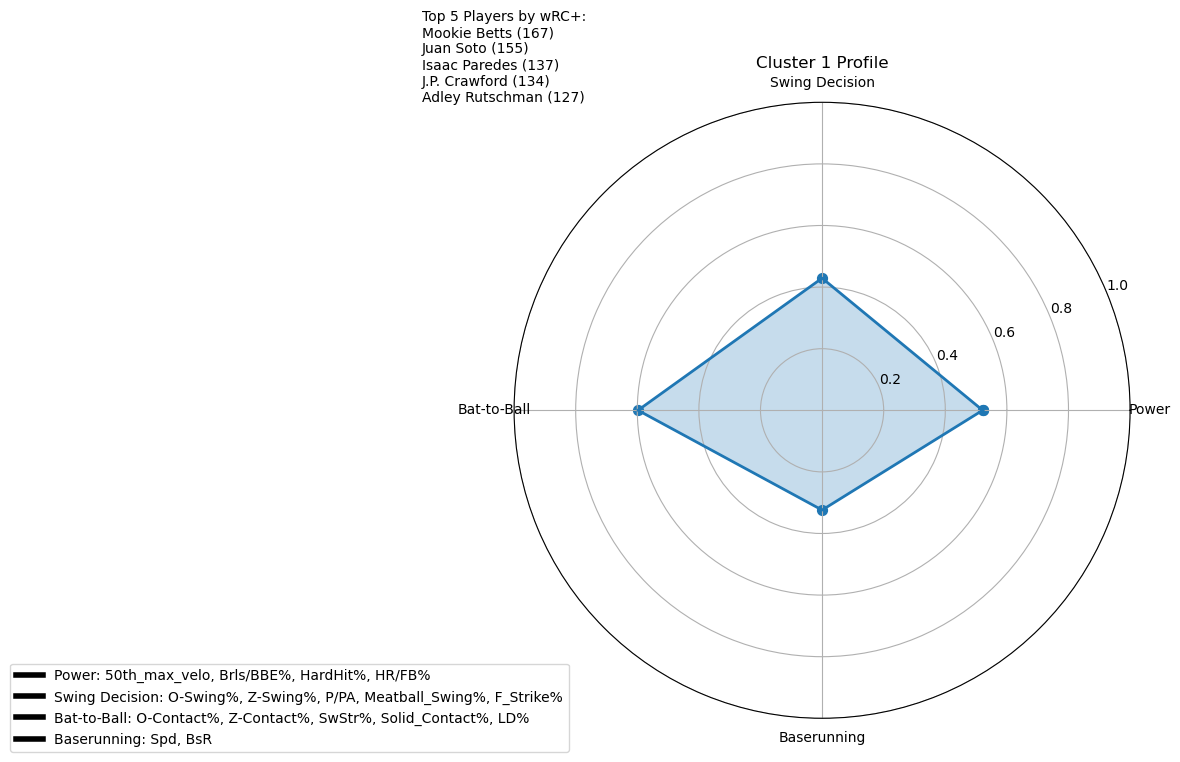

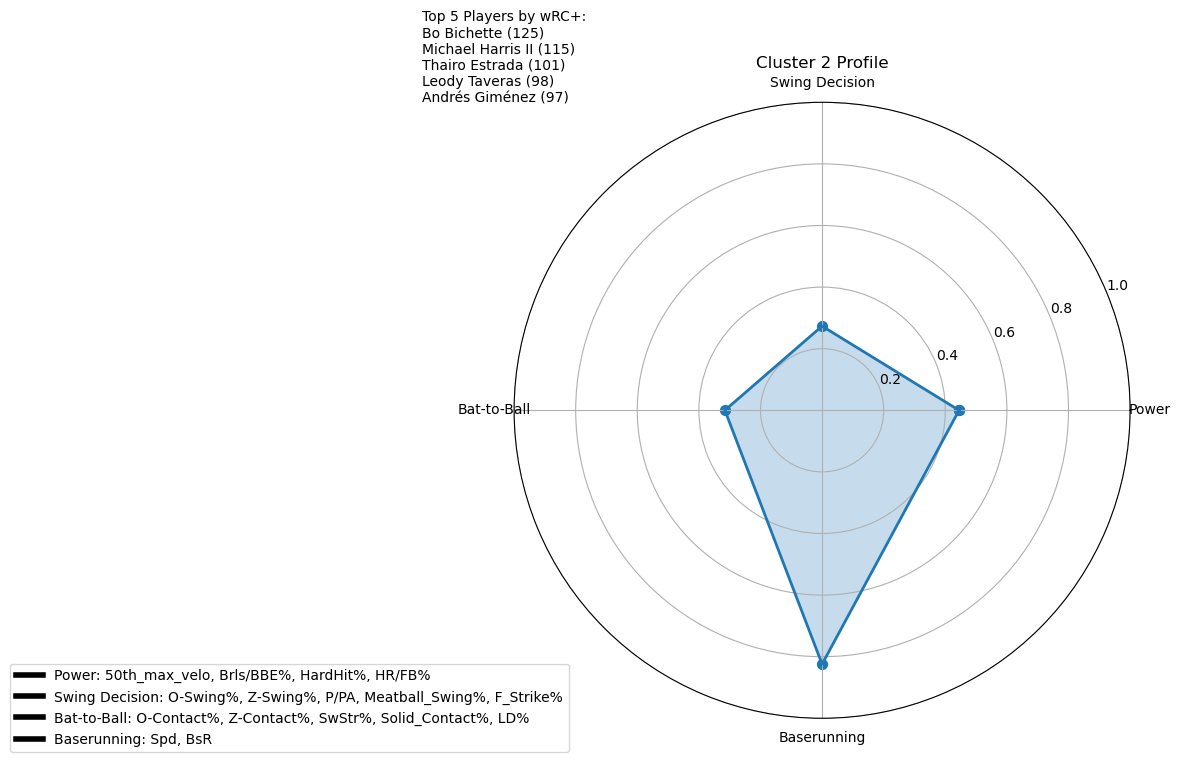

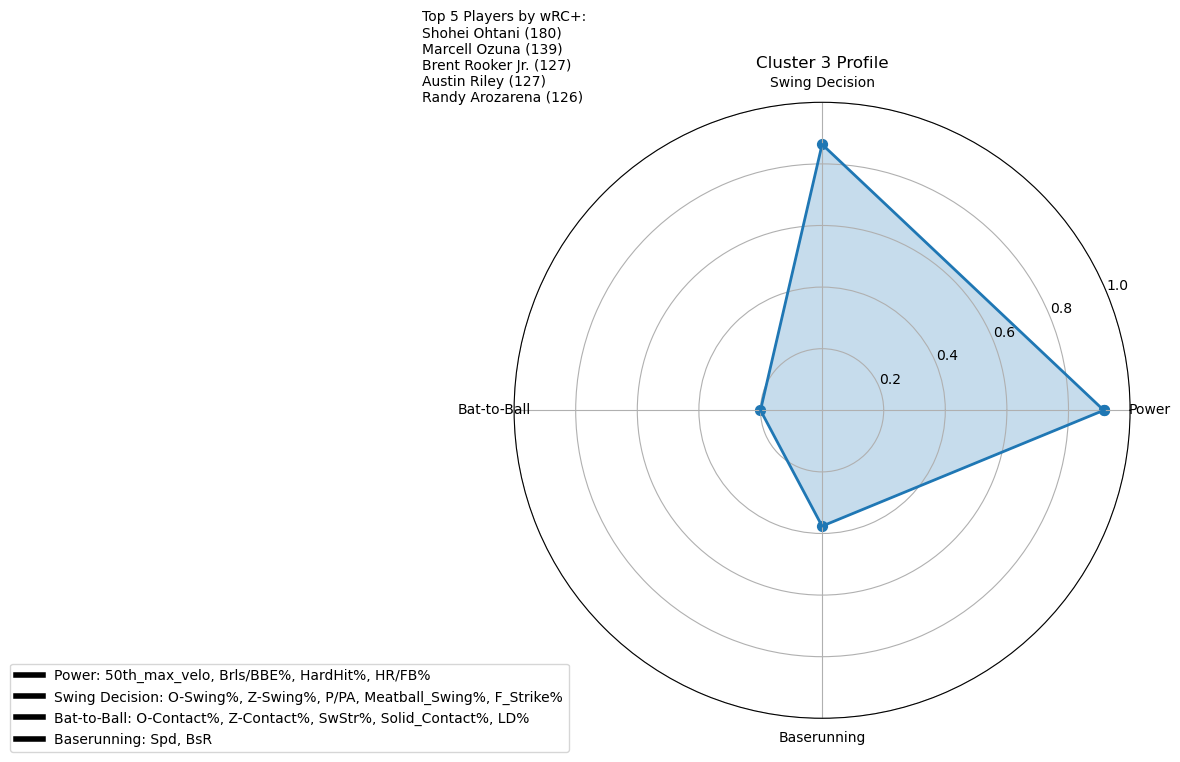

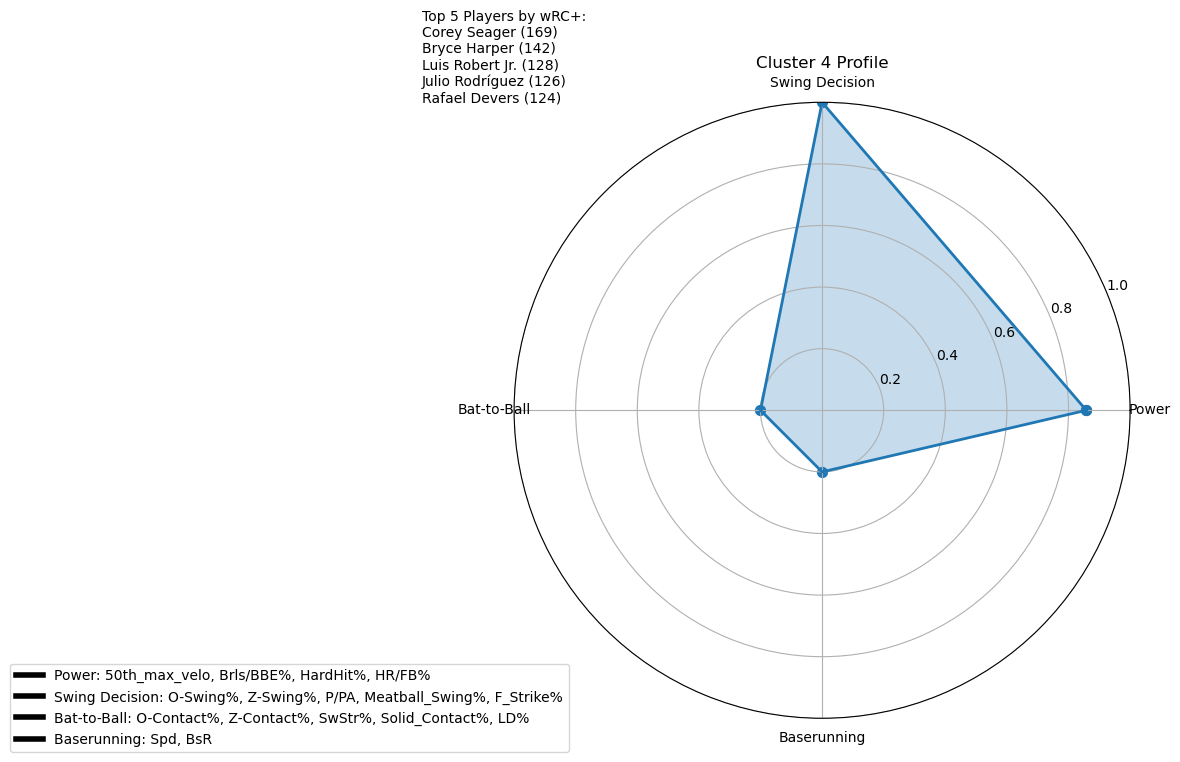

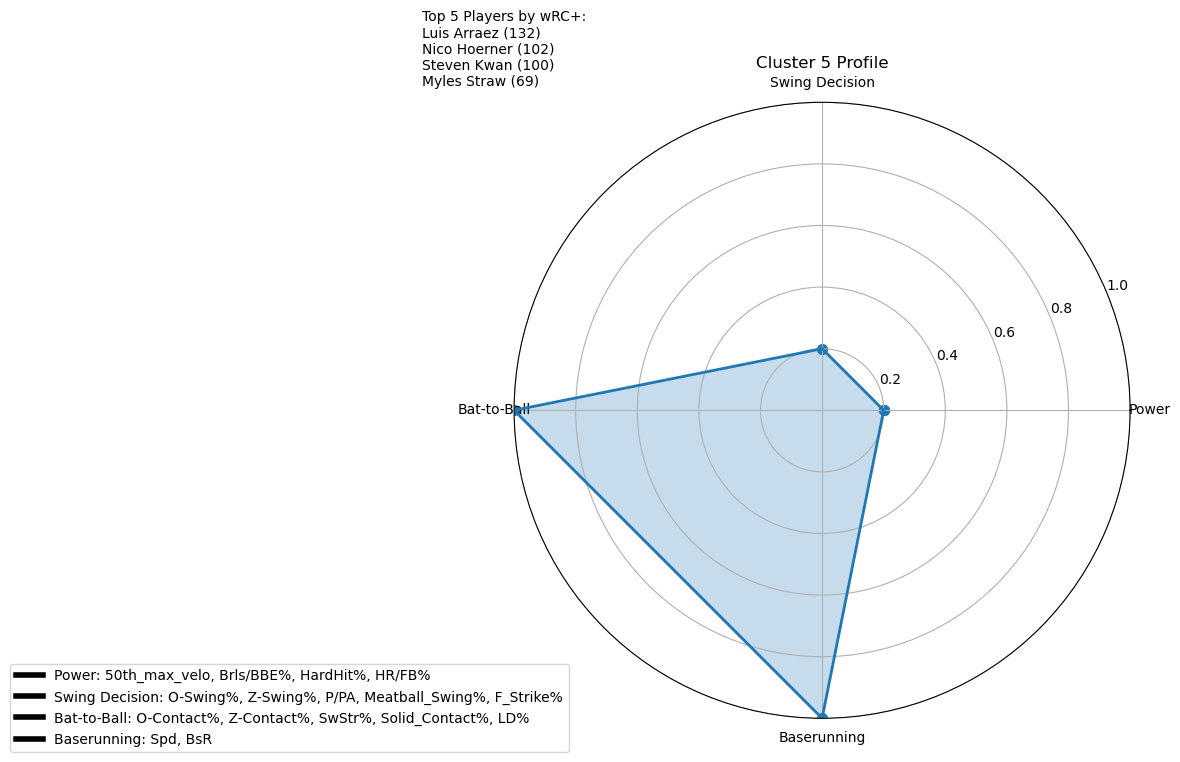

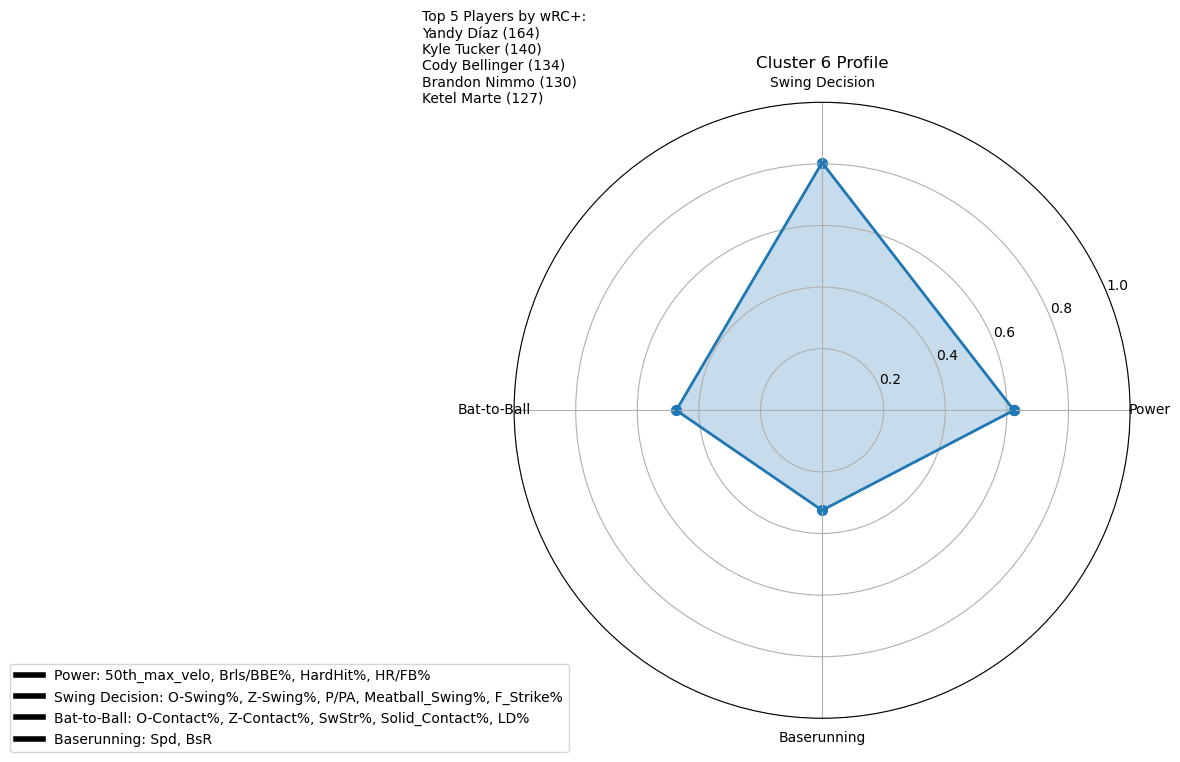

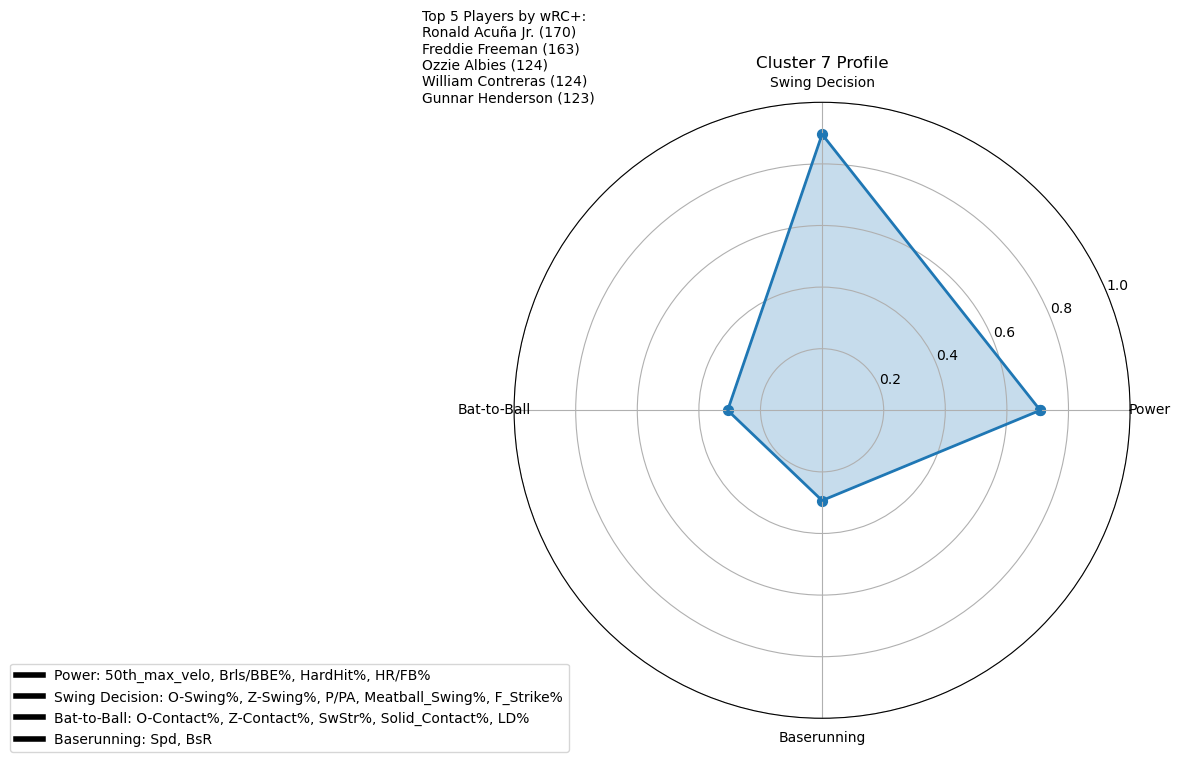

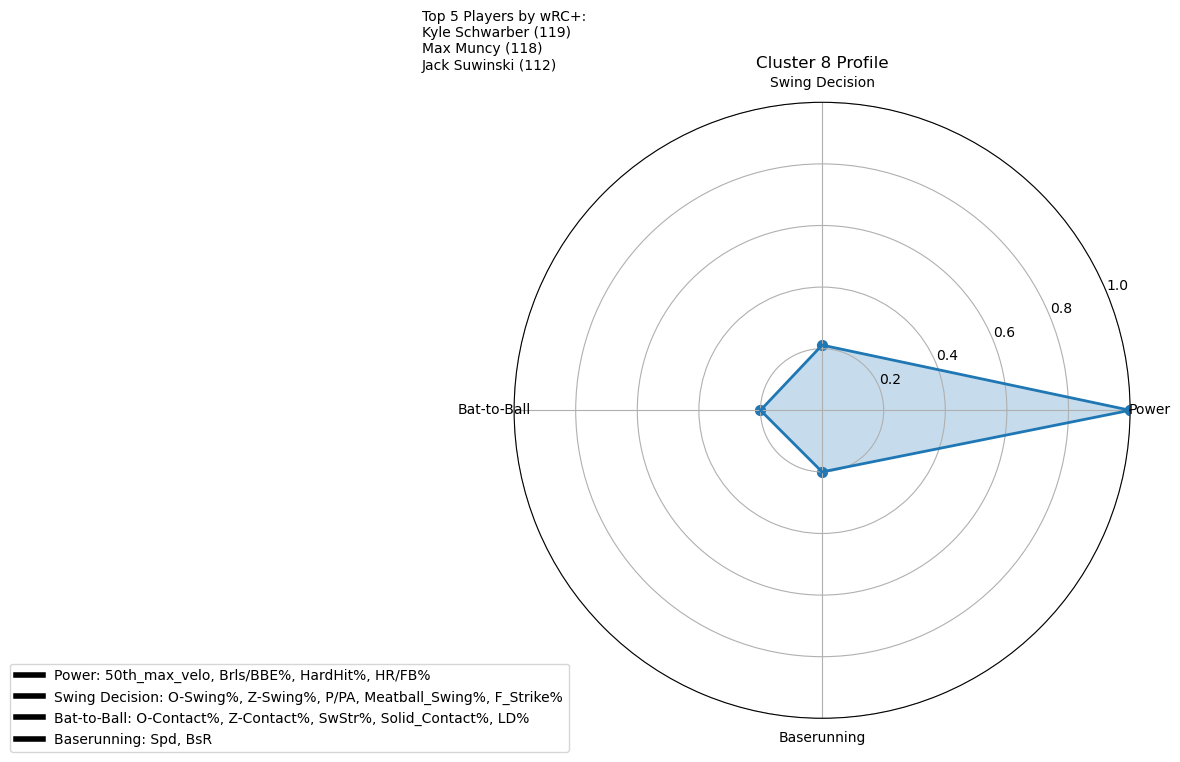

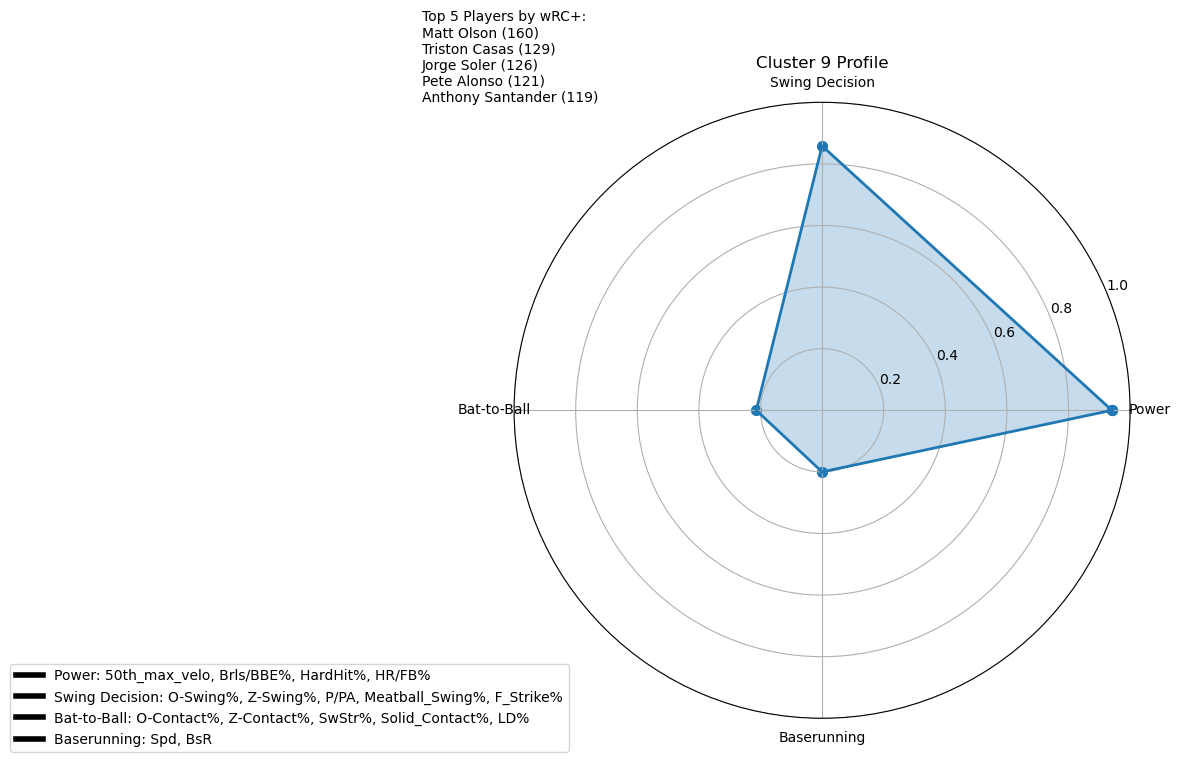

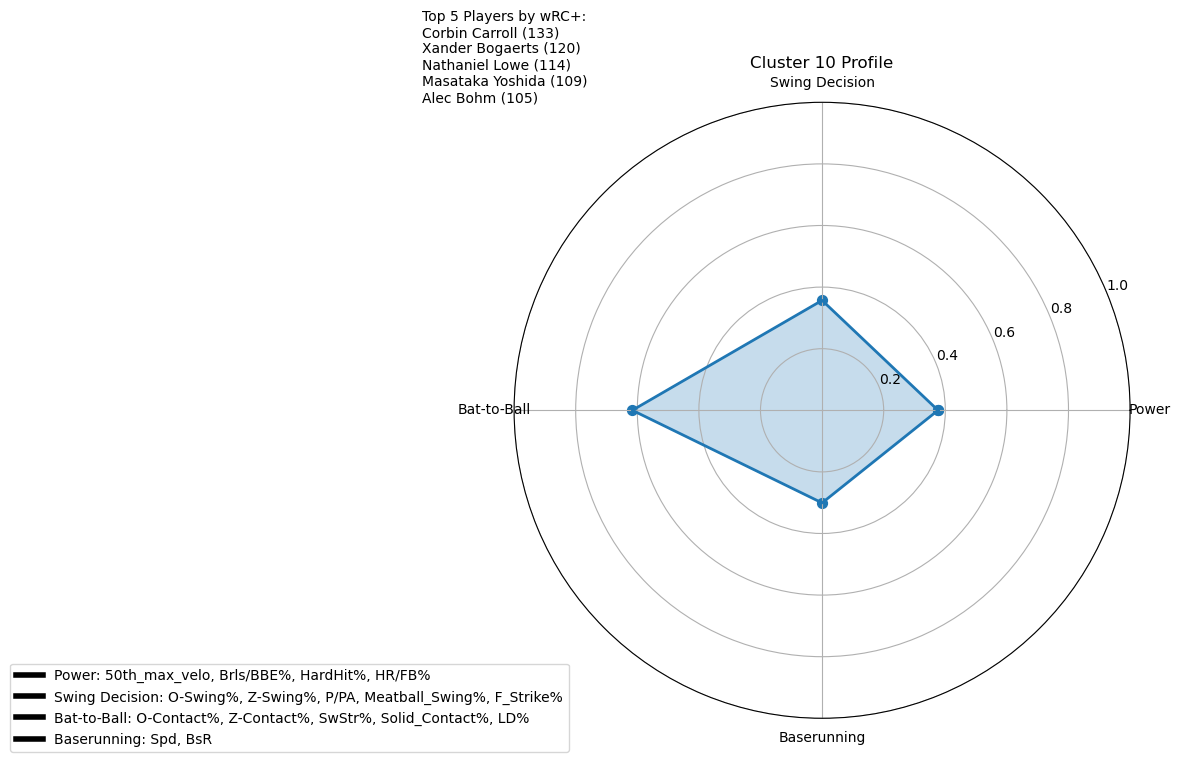

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/stephenak24/Downloads/merged_success_v55.csv'
merged_df = pd.read_csv(file_path)

 
category_features = {
    'Power': ['50th_max_velo', 'Brls/BBE%', 'HardHit%', 'HR/FB%'],
    'Swing Decision': ['O-Swing%', 'Z-Swing%', 'P/PA', 'Meatball_Swing%', 'F_Strike%'],
    'Bat-to-Ball': ['O-Contact%', 'Z-Contact%', 'SwStr%', 'Solid_Contact%', 'LD%'],
    'Baserunning': ['Spd', 'BsR']
}


weights = {
    '50th_max_velo': 0.1748 * 5.875,    
    'Brls/BBE%': 0.3188 * 5.875,      
    'HardHit%': 0.2400 * 5.875,      
    'HR/FB%': 0.2664 * 5.875,         
    'O-Swing%': 0.3005 * 5.875,        
    'Z-Swing%': 0.1764 * 5.875,       
    'P/PA': 0.0957 * 5.875,           
    'Meatball_Swing%': 0.3636 * 5.875,
    'F_Strike%': 0.0638 * 5.875,            
    'O-Contact%': 0.2230 * 5.875,      
    'Z-Contact%': 0.1834 * 5.875,      
    'SwStr%': 0.1793 * 5.875,          
    'Solid_Contact%': 0.2025 * 5.875,          
    'LD%': 0.2118 * 5.875,             
    'Spd': 0.0726 * 5.875,             
    'BsR': 0.6192 * 5.875
}

# Compute the mean of the features for each category per cluster
cluster_means_list = []

for cluster, data in merged_df.groupby('Cluster'):
    category_means = {}
    for category, features in category_features.items():
        weighted_data = data[features].copy()
        for feature in features:
            # Invert if metric is 'better when lower'
            if feature in ['O-Swing%', 'SwStr%', 'F_Strike%']:
                weighted_data[feature] = 1 - data[feature]
            # Apply weights to all features
            weighted_data[feature] *= weights.get(feature, 1)
        category_means[category] = weighted_data.mean(axis=1).mean()

    cluster_means_list.append(pd.DataFrame(category_means, index=[cluster]))

# Combine all the cluster means into a single DataFrame
cluster_category_means = pd.concat(cluster_means_list)

# Normalize the category means for all features
normalized_category_means = (cluster_category_means - cluster_category_means.min()) / (cluster_category_means.max() - cluster_category_means.min())

# Ensure all values are at least 0.2 after normalization
normalized_category_means = np.maximum(normalized_category_means, 0.2)

# Plotting for each cluster with the inclusion of the top players and updated legend
num_clusters = merged_df['Cluster'].nunique()
num_vars = len(category_features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Define the range of values for the radial axis labels
r_values = np.linspace(0.2, 1.0, 5)  # This will create an array [0.2, 0.4, 0.6, 0.8, 1.0]

# Sort merged_df by 'wRC+' within each cluster
merged_df_sorted = merged_df.sort_values(by=['Cluster', 'wRC+'], ascending=[True, False])

# Select top 5 players by 'wRC+' for each cluster
top_players_by_cluster = merged_df_sorted.groupby('Cluster').head(5)

for i in range(num_clusters):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    values = normalized_category_means.iloc[i].tolist()
    values += values[:1]  # complete the loop
    
    ax.plot(angles, values, color='#1f77b4', linewidth=2, linestyle='solid', label=f'Cluster {i+1}')
    ax.fill(angles, values, color='#1f77b4', alpha=0.25)
    ax.scatter(angles, values, color='#1f77b4', s=50)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(category_features.keys())
    
    ax.set_ylim(0, 1.0)
    ax.set_yticks(r_values)
    ax.set_yticklabels(['{:.1f}'.format(i) for i in r_values])
    
    top_players = top_players_by_cluster[top_players_by_cluster['Cluster'] == i+1]
    player_text = 'Top 5 Players by wRC+:\n' + '\n'.join(
        f"{row['Name']} ({row['wRC+']})" for index, row in top_players.iterrows()
    )
    
    plt.text(-0.15, 1.15, player_text, transform=ax.transAxes, fontsize=10, 
             verticalalignment='top', horizontalalignment='left')
    
    legend_labels = [
        f"Power: {', '.join(category_features['Power'])}",
        f"Swing Decision: {', '.join(category_features['Swing Decision'])}",
        f"Bat-to-Ball: {', '.join(category_features['Bat-to-Ball'])}",
        f"Baserunning: {', '.join(category_features['Baserunning'])}"
    ]
    
    ax.legend(handles=[plt.Line2D([0], [0], color='black', lw=4, label=label) for label in legend_labels],
              loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title(f'Cluster {i+1} Profile')
    plt.show()
